# Projet 4: Anticipez les besoins en consommation de bâtiments

## Partie 1:  Néttoyage et analyse exploratoire

### Importation des bibliothèques et chargement des données

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import math
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2

Importons notre table que l'on nommera 'data'

In [2]:
data=pd.read_csv('2016_Building_Energy_Benchmarking.csv')
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

In [3]:
print('la dimension de la table est ',data.shape)

la dimension de la table est  (3376, 46)


In [4]:
pd.set_option('display.max_columns', 46)
pd.set_option('display.max_rows', 1000)

In [5]:
#Observons les différentes colonnes de notre table 'df'
data.columns.tolist()

['OSEBuildingID',
 'DataYear',
 'BuildingType',
 'PrimaryPropertyType',
 'PropertyName',
 'Address',
 'City',
 'State',
 'ZipCode',
 'TaxParcelIdentificationNumber',
 'CouncilDistrictCode',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'YearsENERGYSTARCertified',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'DefaultData',
 'Comments',
 'ComplianceStatus',
 'Outlier',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity']

<AxesSubplot:ylabel='None'>

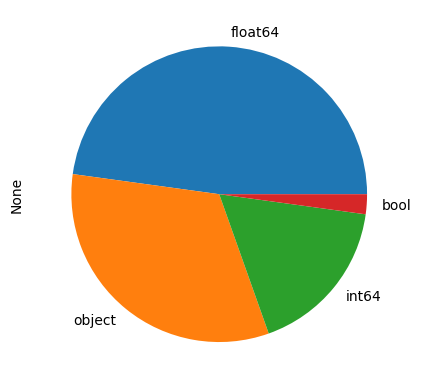

In [6]:
#la repartition des features par types
data.dtypes.value_counts().plot.pie()

<AxesSubplot:>

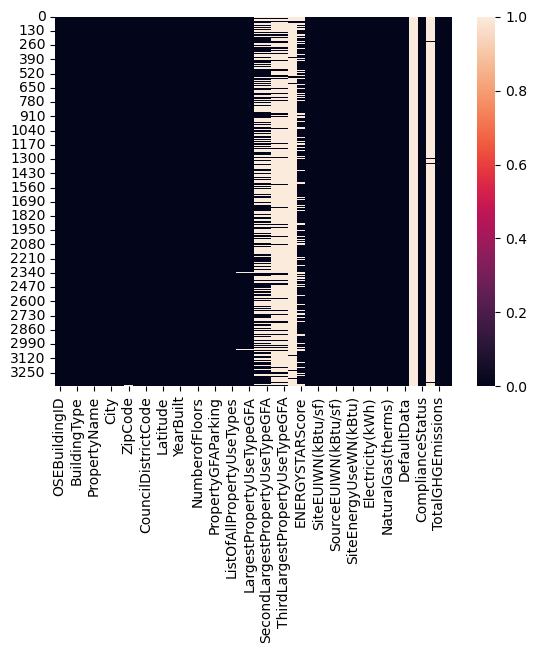

In [7]:
#remplissage des données
sns.heatmap(data.isna())

In [8]:
#les valeurs manquantes 
data.isna().sum().sum()

19952

## Néttoyage des données 

Observons la repartition des features 'Outlier'

In [9]:
data['Outlier'].unique()

array([nan, 'High outlier', 'Low outlier'], dtype=object)

In [10]:
data['Outlier'].value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

Il y a dans la liste, 9 bâtiments classés 'High outlier', et 23 classés 'Low outlier'. Nous choisissons de supprimers les bâtiments présents dans cette liste.

In [11]:
#selections des bâtiments qui ne sont pas pésents dans la liste outliers 
data=data[data['Outlier'].isna()]
data.shape

(3344, 46)

Analysons egalement la variable 'ComplianceStatus'

In [12]:
data['ComplianceStatus'].unique()

array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

In [13]:
data['ComplianceStatus'].value_counts()

Compliant                       3211
Error - Correct Default Data     111
Missing Data                      15
Non-Compliant                      7
Name: ComplianceStatus, dtype: int64

Nous selectionerons les bâtiments "Compliant"

In [14]:
#selection des bâtiments "Compliant"
data=data[data['ComplianceStatus']== "Compliant"]
data.shape

(3211, 46)

In [15]:
#creation de la colonne 'BuildingAge'
for i in data.index:
    data.loc[i,'BuildingAge'] = data.loc[i,'DataYear'] - data.loc[i,'YearBuilt']

#### Selection de variables pertinentes pour repondre à notre problématique

In [16]:
#selection des variables:
variables=['BuildingAge','BuildingType','PrimaryPropertyType','Neighborhood','NumberofBuildings',
 'NumberofFloors','PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
           'SiteEnergyUseWN(kBtu)',
           'SiteEUIWN(kBtu/sf)',
           'TotalGHGEmissions',
           'GHGEmissionsIntensity',
           'ENERGYSTARScore',
          'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',]

In [17]:
data=data[variables]

#### les différents types de variables 

In [18]:
cont_feats = [col for col in data.columns if data[col].dtype != object]
cat_feats = [col for col in data.columns if col not in cont_feats]
print("les variables numériques so nt: ",  cont_feats)
print("les variables categorielles sont: ",cat_feats)

les variables numériques so nt:  ['BuildingAge', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'ENERGYSTARScore', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']
les variables categorielles sont:  ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']


In [19]:
#Notre analyse concernera les bâtiments non destinés à l'habitation. Nous ne selectionnerons que ces bâtimnents là,
data['BuildingType'].unique()


array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'Campus', 'SPS-District K-12', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [20]:
#selection de bâtiments non destinés à l’habitation
data=data[~data['BuildingType'].str.contains('Multifamily')]
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Campus',
       'SPS-District K-12', 'Nonresidential WA'], dtype=object)

### Traitement des valeurs abbérantes 

In [21]:
data.describe()

BuildingAge  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  1548.000000        1548.000000     1548.000000      1.548000e+03   
mean     54.355943           1.178941        4.276486      1.213321e+05   
std      32.886918           3.039221        6.780694      3.062944e+05   
min       1.000000           0.000000        0.000000      1.128500e+04   
25%      27.000000           1.000000        1.000000      2.884325e+04   
50%      50.500000           1.000000        2.000000      4.815900e+04   
75%      86.000000           1.000000        4.000000      1.076615e+05   
max     116.000000         111.000000       99.000000      9.320156e+06   

       PropertyGFAParking  PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count         1548.000000            1.548000e+03               1.544000e+03   
mean         13842.337209            1.074898e+05               9.994564e+04   
std          43721.822291            2.926272e+05               2.855014e+05   
min              0.000000            3.636000e+03               5.656000e+03   
25%              0.000000            2.793675e+04               2.501575e+04   
50%              0.000000            4.608400e+04               4.204300e+04   
75%              0.000000            9.556825e+04               9.203675e+04   
max         512608.000000            9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                       842.000000                      348.000000   
mean                      36342.497977                    14998.889077   
std                       66631.152358                    37037.015147   
min                           0.000000                        0.000000   
25%                        5564.250000                     2624.250000   
50%                       12062.500000                     5965.500000   
75%                       31820.250000                    12965.500000   
max                      639931.000000                   459748.000000   

       SiteEnergyUseWN(kBtu)  SiteEUIWN(kBtu/sf)  TotalGHGEmissions  \
count           1.547000e+03         1547.000000        1548.000000   
mean            8.441981e+06           77.525857         193.608908   
std             2.277676e+07           76.235063         779.105278   
min             0.000000e+00            0.000000          -0.800000   
25%             1.322090e+06           37.000000          20.655000   
50%             2.824097e+06           56.299999          49.845000   
75%             7.470130e+06           87.900002         147.227500   
max             4.716139e+08          834.400024       16870.980000   

       GHGEmissionsIntensity  ENERGYSTARScore  SteamUse(kBtu)  \
count            1548.000000       997.000000    1.548000e+03   
mean                1.667358        63.635908    5.511831e+05   
std                 2.407577        28.825309    5.718502e+06   
min                -0.020000         1.000000    0.000000e+00   
25%                 0.360000        44.000000    0.000000e+00   
50%                 0.880000        71.000000    0.000000e+00   
75%                 1.960000        88.000000    0.000000e+00   
max                34.090000       100.000000    1.349435e+08   

       Electricity(kBtu)  NaturalGas(kBtu)  
count       1.548000e+03      1.548000e+03  
mean        6.140840e+06      2.038297e+06  
std         2.151071e+07      9.710667e+06  
min        -1.154170e+05      0.000000e+00  
25%         7.308642e+05      0.000000e+00  
50%         1.746086e+06      4.881350e+05  
75%         5.264935e+06      1.530812e+06  
max         6.570744e+08      2.979090e+08

il y a des valeurs négatives dans notre table. Nous allons supprimer ces valeurs pour la suite de notre analyse.

In [22]:
#suppression des valeurs negatives
for var in cont_feats :
    data.drop(data.loc[(data[var]<0),:].index, inplace=True)


Dans la variable 'NumberofBuildings', certains batiments ont une valeur de 0. Nous allons égalements supprimer ces batiments.

In [23]:
 #suppression de certains bâtiments ayant des valeurs à 0 
indexNames = data[ data['NumberofBuildings'] == 0 ].index
data.drop(indexNames , inplace=True)

### * Traitement des valeurs abbérantes des colonnes 'gfa'

In [24]:
#les valeurs abérrantes gfa
data =  data[~((data['LargestPropertyUseTypeGFA'] > data['PropertyGFATotal']) 
                              | (data['PropertyGFABuilding(s)'] > data['PropertyGFATotal']) 
                              | (data['PropertyGFAParking'] > data['PropertyGFATotal']) 
                              | (data['SecondLargestPropertyUseTypeGFA'] > data['LargestPropertyUseTypeGFA'])
                              | (data['ThirdLargestPropertyUseTypeGFA'] > data['SecondLargestPropertyUseTypeGFA'])
                               )]
print(data.shape)


(1322, 23)


### * Traitement des valeurs abbérantes par la methode knn

In [25]:
from sklearn.neighbors import KDTree

for column in data.select_dtypes(include = ['int32','float64']).columns.tolist() :
    "outliers aux extrémités des distributions"
    data.loc[data[column] > data[column].quantile(0.995)] = np.nan
    data.loc[data[column] < data[column].quantile(0.005)] = np.nan
print(data.shape)
    
#outliers éloignés par rapport à leurs voisins
numeric_data = data.select_dtypes(['int32', 'float64']).copy().dropna()
print(numeric_data.shape)
kdt = KDTree(numeric_data, leaf_size = 40, metric='minkowski')

dist, ind = kdt.query(numeric_data, k=3, return_distance=True)
numeric_data['3N_distance'] = np.sum(dist, axis=1)    
numeric_data = numeric_data[numeric_data['3N_distance'] < numeric_data['3N_distance'].quantile(0.99)]
index_to_drop = numeric_data.index.tolist()

data = data.drop(index_to_drop, axis=0)
    



(1322, 23)
(126, 17)


### Les variables catégorielles 

In [26]:
#filtrage des données des catégories batiments:

for col in cat_feats: 
    print('-'*80)
    print('Le nombre de valeurs que peuvent prendre la colone :', col)
    print(data[col].nunique())
    print('Les valeurs que peuvent prendre la colone :', col)
    print('\n')
    print(data[col].unique())



--------------------------------------------------------------------------------
Le nombre de valeurs que peuvent prendre la colone : BuildingType
4
Les valeurs que peuvent prendre la colone : BuildingType


['NonResidential' nan 'Nonresidential COS' 'SPS-District K-12' 'Campus']
--------------------------------------------------------------------------------
Le nombre de valeurs que peuvent prendre la colone : PrimaryPropertyType
20
Les valeurs que peuvent prendre la colone : PrimaryPropertyType


['Hotel' nan 'Other' 'Mixed Use Property' 'University'
 'Small- and Mid-Sized Office' 'Self-Storage Facility' 'Warehouse'
 'K-12 School' 'Senior Care Community' 'Residence Hall' 'Retail Store'
 'Distribution Center' 'Worship Facility' 'Medical Office' 'Large Office'
 'Laboratory' 'Supermarket / Grocery Store' 'Refrigerated Warehouse'
 'Low-Rise Multifamily' 'Restaurant']
--------------------------------------------------------------------------------
Le nombre de valeurs que peuvent prendre 

In [27]:
targets=["TotalGHGEmissions", 'SiteEnergyUseWN(kBtu)']

In [28]:
#Regroupement des catégories d'usage des bâtiments
colonneUseProprety = ['LargestPropertyUseType' , 'PrimaryPropertyType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType']


In [29]:
usetype_dict = {'Retail Store' : 'Retail',
                'Supermarket/Grocery Store' : 'Retail',
                'Repair Services (Vehicle, Shoe, Locksmith, etc)' : 'Retail',
                'Automobile Dealership': 'Retail',
                'Convenience Store without Gas Station': 'Retail',
                'Personal Services': 'Retail',
                'Enclosed Mall': 'Retail',
                'Strip Mall': 'Retail',
                'Wholesale Club/Supercenter': 'Retail',
                'Other - Mall': 'Retail',
                'Supermarket / Grocery Stor': 'Retail',
                
                'Food Sales': 'Leisure',
                'Restaurant' : 'Leisure',
                'Other - Restaurant/Bar' : 'Leisure',
                'Food Service': 'Leisure' ,
                'Worship Facility': 'Leisure',
                'Other - Recreation': 'Leisure',
                'Other - Entertainment/Public Assembly': 'Leisure',
                'Performing Arts': 'Leisure',
                'Bar/Nightclub': 'Leisure',
                'Movie Theater': 'Leisure',
                'Museum': 'Leisure',
                'Social/Meeting Hall': 'Leisure',
                'Fitness Center/Health Club/Gym': 'Leisure',
                'Lifestyle Center ': 'Leisure',
                'Fast Food Restaurant': 'Leisure',
                
                'Multifamily Housing' : 'Hotel/Senior Care/Housing',
                'Other - Lodging/Residential': 'Hotel/Senior Care/Housing',
                'Residence Hall/Dormitory': 'Hotel/Senior Care/Housing',
                'Hotel' : 'Hotel/Senior Care/Housing',
                'Senior Care Community' : 'Hotel/Senior Care/Housing',
                'Residential Care Facility' : 'Hotel/Senior Care/Housing',
                'High-Rise Multifamily': 'Hotel/Senior Care/Housing',
                
                'Medical Office' : 'Health',
                
                'Other - Services' : 'Office',
                'Bank Branch' : 'Office',
                'Financial Office' : 'Office',
                'Other - Public Services': 'Office',

                'K-12 School' : 'Education',
                'Other - Education': 'Education',
                'Vocational School' : 'Education', 
                'Adult Education' : 'Education',
                'Pre-school/Daycare': 'Education',
                'University': 'Education',
                'College/University': 'Education',
                'Library': 'Education'
               }

colonneUseProprety = ['LargestPropertyUseType' , 'PrimaryPropertyType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType']
for column in colonneUseProprety:
     data[column] = data[column].replace(usetype_dict)


In [30]:
#correction de libellés
data['Neighborhood'].replace('Central', 'CENTRAL', inplace=True)
data['Neighborhood'].replace('Ballard', 'BALLARD', inplace=True)
data['Neighborhood'].replace('North', 'NORTH', inplace=True)
data['Neighborhood'].replace('Northwest', 'NORTHWEST', inplace=True)
data['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE', inplace=True)
data['Neighborhood'].replace('Delridge', 'DELRIDGE', inplace=True)


In [31]:
data['PrimaryPropertyType']= data['PrimaryPropertyType'].replace('Distribution Center\n','Distribution Center')
data['PrimaryPropertyType']= data['PrimaryPropertyType'].replace('Self-Storage Facility\n','Self-Storage Facility')
data['PrimaryPropertyType']= data['PrimaryPropertyType'].replace('Supermarket / Grocery Store','Retail')
data['PrimaryPropertyType']= data['PrimaryPropertyType'].replace('Restaurant\n','Leisure')


## Traitement des valeurs manquantes 

In [32]:
#les valeurs manquantes 
#classement des données manquantes par colonnes
(data.isna().sum()/data.shape[0]).sort_values(ascending=False)

ThirdLargestPropertyUseType        0.873957
ThirdLargestPropertyUseTypeGFA     0.873957
SecondLargestPropertyUseType       0.528381
SecondLargestPropertyUseTypeGFA    0.528381
ENERGYSTARScore                    0.424875
LargestPropertyUseType             0.086811
LargestPropertyUseTypeGFA          0.086811
SiteEUIWN(kBtu/sf)                 0.084307
SiteEnergyUseWN(kBtu)              0.084307
Electricity(kBtu)                  0.083472
SteamUse(kBtu)                     0.083472
GHGEmissionsIntensity              0.083472
TotalGHGEmissions                  0.083472
BuildingAge                        0.083472
BuildingType                       0.083472
PropertyGFABuilding(s)             0.083472
PropertyGFAParking                 0.083472
PropertyGFATotal                   0.083472
NumberofFloors                     0.083472
NumberofBuildings                  0.083472
Neighborhood                       0.083472
PrimaryPropertyType                0.083472
NaturalGas(kBtu)                

In [33]:
#Suppression des Nan correspondants aux outliers detectés plus tôt
data=data.dropna(subset=['BuildingAge',])

In [34]:
(data.isna().sum()/data.shape[0]).sort_values(ascending=False)

ThirdLargestPropertyUseType        0.862477
ThirdLargestPropertyUseTypeGFA     0.862477
SecondLargestPropertyUseType       0.485428
SecondLargestPropertyUseTypeGFA    0.485428
ENERGYSTARScore                    0.372495
LargestPropertyUseType             0.003643
LargestPropertyUseTypeGFA          0.003643
SiteEUIWN(kBtu/sf)                 0.000911
SiteEnergyUseWN(kBtu)              0.000911
Electricity(kBtu)                  0.000000
SteamUse(kBtu)                     0.000000
GHGEmissionsIntensity              0.000000
TotalGHGEmissions                  0.000000
BuildingAge                        0.000000
BuildingType                       0.000000
PropertyGFABuilding(s)             0.000000
PropertyGFAParking                 0.000000
PropertyGFATotal                   0.000000
NumberofFloors                     0.000000
NumberofBuildings                  0.000000
Neighborhood                       0.000000
PrimaryPropertyType                0.000000
NaturalGas(kBtu)                

#### Remplacement des Nan par la médiane correspondant au type de bâtiment 

In [35]:
liste=['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA','SiteEnergyUseWN(kBtu)',
'SiteEUIWN(kBtu/sf)']

In [36]:
def nan_float_replace(dataframe):
    ''' Fonction qui prend en entrée un dataframe,
        identifie les valeurs manquantes pour les variables numeriques,
        les remplace par la médiane de cette variable filtré par le type de batiment, et
        retourne le data après traitement
    '''    

    
    
    for col in liste:
        for categ in dataframe['BuildingType'].unique():
            mean_value = np.nanmedian(dataframe.loc[(dataframe['BuildingType']==categ),col])
            if math.isnan(mean_value):
                mean_value = np.nanmedian(dataframe[col])
            dataframe.loc[(dataframe['BuildingType']==categ),col] = dataframe.loc[(dataframe['BuildingType']==categ),col].fillna(mean_value)
            
    return dataframe


In [37]:
nan_float_replace(data)

BuildingAge        BuildingType        PrimaryPropertyType  \
0            89.0      NonResidential  Hotel/Senior Care/Housing   
3            90.0      NonResidential  Hotel/Senior Care/Housing   
5            17.0  Nonresidential COS                      Other   
6            90.0      NonResidential  Hotel/Senior Care/Housing   
7            90.0      NonResidential                      Other   
...           ...                 ...                        ...   
3367        104.0  Nonresidential COS                      Other   
3368         22.0  Nonresidential COS         Mixed Use Property   
3370         34.0  Nonresidential COS                      Other   
3372         12.0  Nonresidential COS                      Other   
3375         78.0  Nonresidential COS         Mixed Use Property   

          Neighborhood  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0             DOWNTOWN                1.0            12.0           88434.0   
3             DOWNTOWN                1.0            10.0           61320.0   
5             DOWNTOWN                1.0             2.0           97288.0   
6             DOWNTOWN                1.0            11.0           83008.0   
7             DOWNTOWN                1.0             8.0          102761.0   
...                ...                ...             ...               ...   
3367              EAST                1.0             1.0           23445.0   
3368           CENTRAL                1.0             1.0           20050.0   
3370          DELRIDGE                1.0             1.0           18261.0   
3372          DOWNTOWN                1.0             1.0           16000.0   
3375  GREATER DUWAMISH                1.0             1.0           18258.0   

      PropertyGFAParking  PropertyGFABuilding(s)     LargestPropertyUseType  \
0                    0.0                 88434.0  Hotel/Senior Care/Housing   
3                    0.0                 61320.0  Hotel/Senior Care/Housing   
5                37198.0                 60090.0             Police Station   
6                    0.0                 83008.0  Hotel/Senior Care/Housing   
7                    0.0                102761.0                    Leisure   
...                  ...                     ...                        ...   
3367                 0.0                 23445.0                    Leisure   
3368                 0.0                 20050.0                    Leisure   
3370                 0.0                 18261.0                    Leisure   
3372                 0.0                 16000.0                    Leisure   
3375                 0.0                 18258.0                    Leisure   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                       88434.0                          NaN   
3                       61320.0                          NaN   
5                       88830.0                          NaN   
6                       81352.0                          NaN   
7                      102761.0                          NaN   
...                         ...                          ...   
3367                    23445.0                          NaN   
3368                     8108.0                      Leisure   
3370                    18261.0                          NaN   
3372                    16000.0                          NaN   
3375                     8271.0                      Leisure   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                             10256.0                         NaN   
3                             10256.0                         NaN   
5                              9848.5                         NaN   
6                             10256.0                         NaN   
7                             10256.0                         NaN   
...                               ...                         ...   
3367                           9848.5  

In [38]:
(data.isna().sum()/data.shape[0]).sort_values(ascending=False)

ThirdLargestPropertyUseType        0.862477
SecondLargestPropertyUseType       0.485428
ENERGYSTARScore                    0.372495
LargestPropertyUseType             0.003643
SecondLargestPropertyUseTypeGFA    0.000000
Electricity(kBtu)                  0.000000
SteamUse(kBtu)                     0.000000
GHGEmissionsIntensity              0.000000
TotalGHGEmissions                  0.000000
SiteEUIWN(kBtu/sf)                 0.000000
SiteEnergyUseWN(kBtu)              0.000000
ThirdLargestPropertyUseTypeGFA     0.000000
BuildingAge                        0.000000
BuildingType                       0.000000
LargestPropertyUseTypeGFA          0.000000
PropertyGFABuilding(s)             0.000000
PropertyGFAParking                 0.000000
PropertyGFATotal                   0.000000
NumberofFloors                     0.000000
NumberofBuildings                  0.000000
Neighborhood                       0.000000
PrimaryPropertyType                0.000000
NaturalGas(kBtu)                

### Remplacement des Nan des variables catégorielles 

In [39]:
data=data.fillna({'LargestPropertyUseType':'Unknow', 'SecondLargestPropertyUseType':'Unknow','ThirdLargestPropertyUseType':'Unknow'})

In [40]:
(data.isna().sum()/data.shape[0]).sort_values(ascending=False)

ENERGYSTARScore                    0.372495
BuildingAge                        0.000000
SecondLargestPropertyUseTypeGFA    0.000000
Electricity(kBtu)                  0.000000
SteamUse(kBtu)                     0.000000
GHGEmissionsIntensity              0.000000
TotalGHGEmissions                  0.000000
SiteEUIWN(kBtu/sf)                 0.000000
SiteEnergyUseWN(kBtu)              0.000000
ThirdLargestPropertyUseTypeGFA     0.000000
ThirdLargestPropertyUseType        0.000000
SecondLargestPropertyUseType       0.000000
BuildingType                       0.000000
LargestPropertyUseTypeGFA          0.000000
LargestPropertyUseType             0.000000
PropertyGFABuilding(s)             0.000000
PropertyGFAParking                 0.000000
PropertyGFATotal                   0.000000
NumberofFloors                     0.000000
NumberofBuildings                  0.000000
Neighborhood                       0.000000
PrimaryPropertyType                0.000000
NaturalGas(kBtu)                

#### features ingeneering

In [41]:
#On calcule la surface réelle d'un bâtiment 
data["Surface"] = data['NumberofFloors'] * data["PropertyGFABuilding(s)"]

In [42]:
#On calcule le nombre de source d'énergie par bâtiment 
rag=data[['SteamUse(kBtu)','Electricity(kBtu)',
          'NaturalGas(kBtu)']]
nb=(rag == 0).sum(1)
data['energytype_count'] = 3-nb
data.drop(data[data['energytype_count']==0].index, inplace=True, axis=0)

# Analyse exploratoire

### Analyse univariée

#### Histogrammes des variables continues 

C:\Users\mr_ar\AppData\Local\Temp\ipykernel_27644\1217623266.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[col]).set_title("histogramme de la variable " +col)
C:\Users\mr_ar\AppData\Local\Temp\ipykernel_27644\1217623266.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[col]).se

C:\Users\mr_ar\AppData\Local\Temp\ipykernel_27644\1217623266.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[col]).set_title("histogramme de la variable " +col)
C:\Users\mr_ar\AppData\Local\Temp\ipykernel_27644\1217623266.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[col]).se

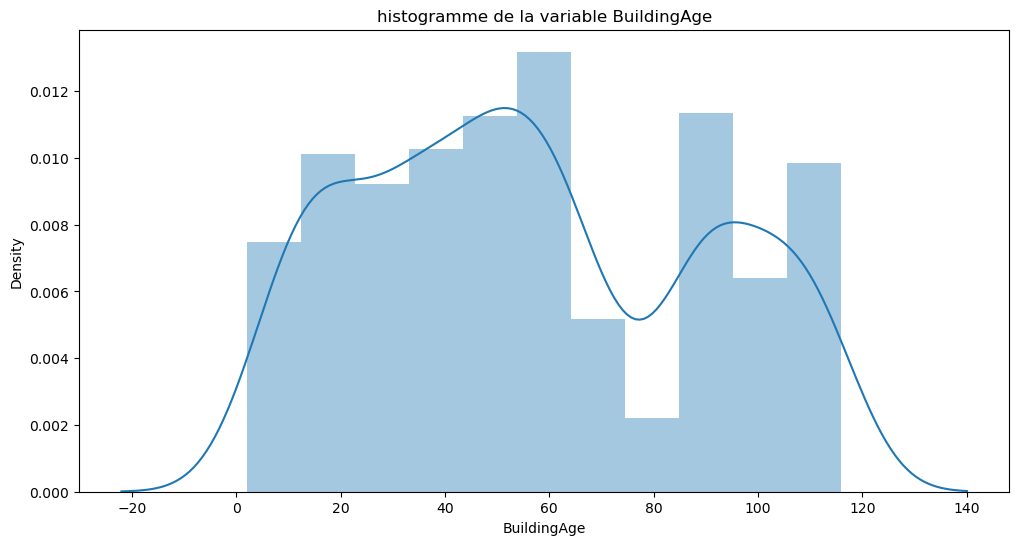

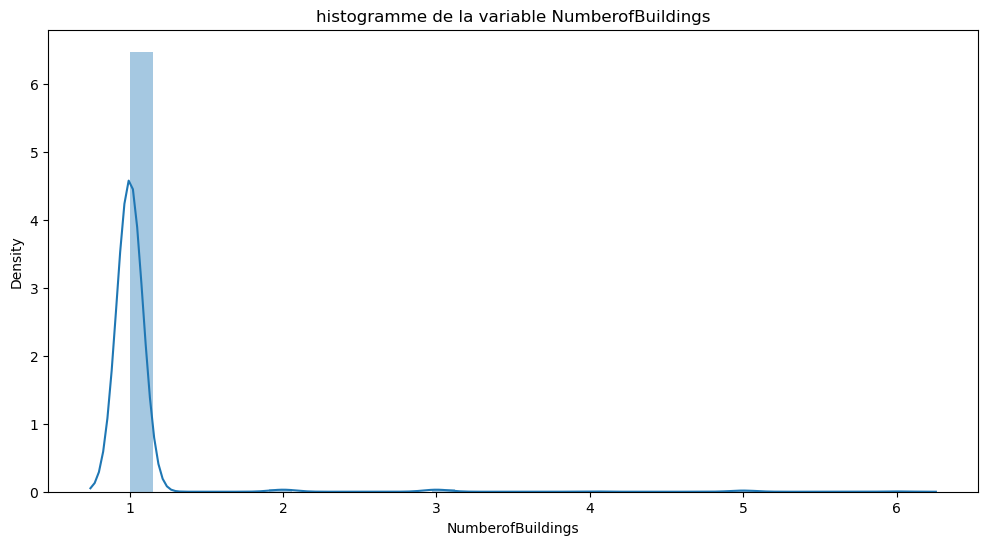

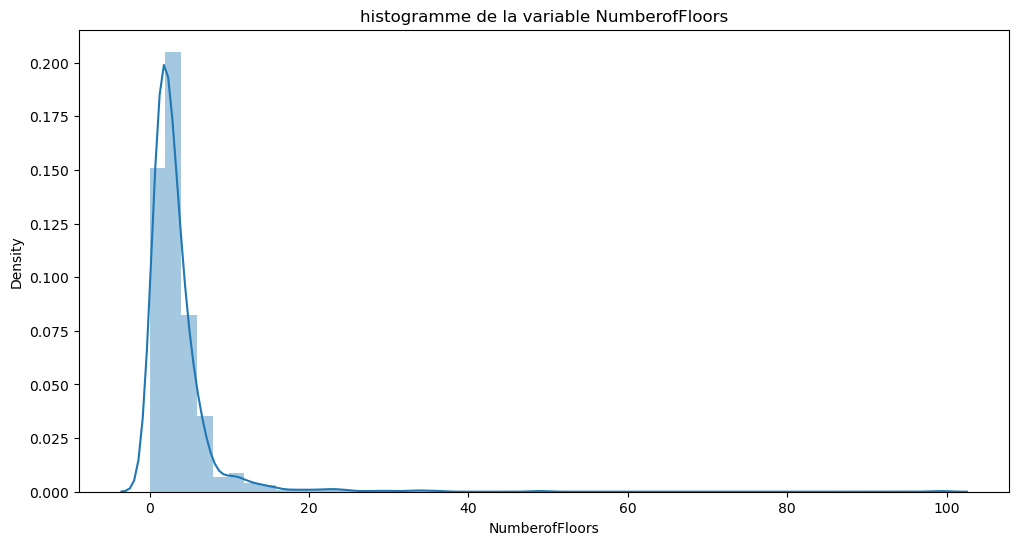

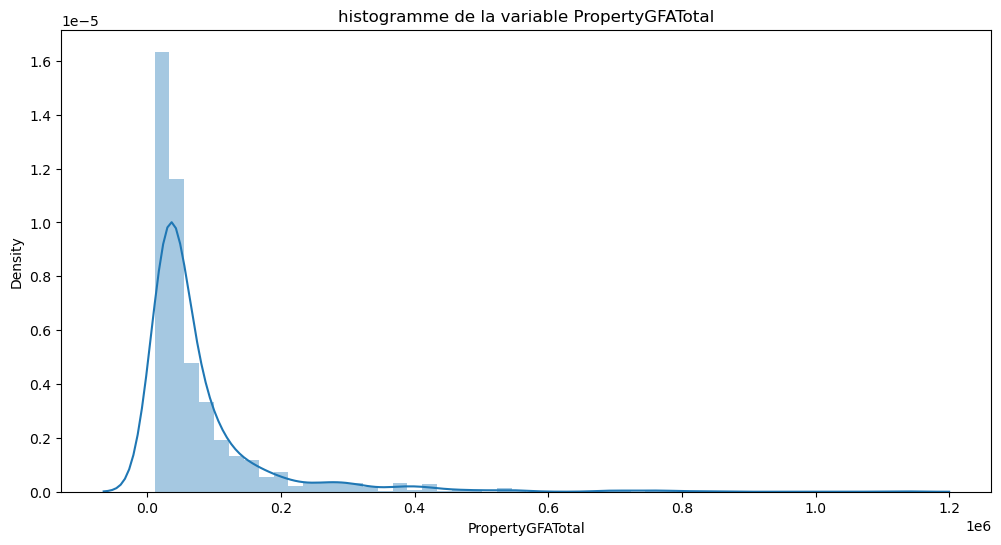

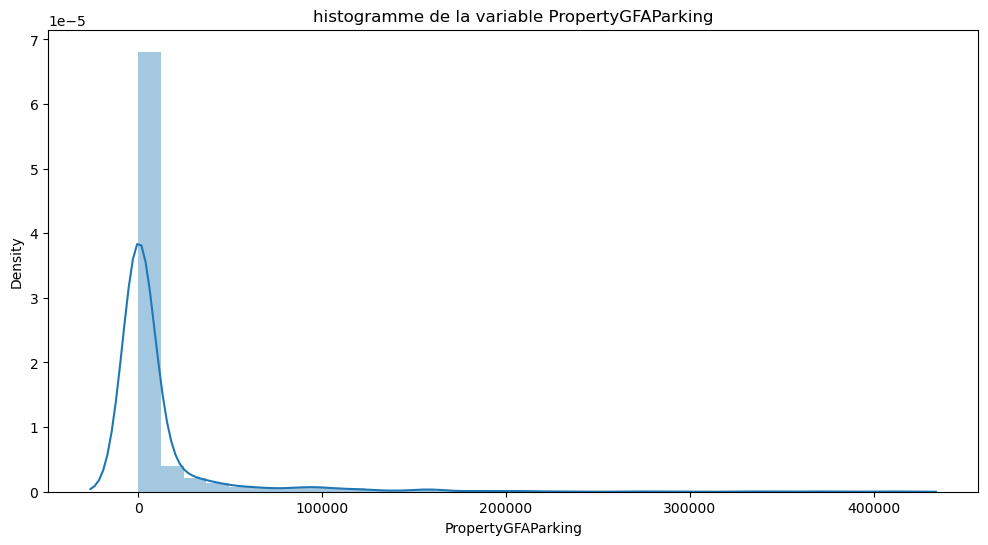

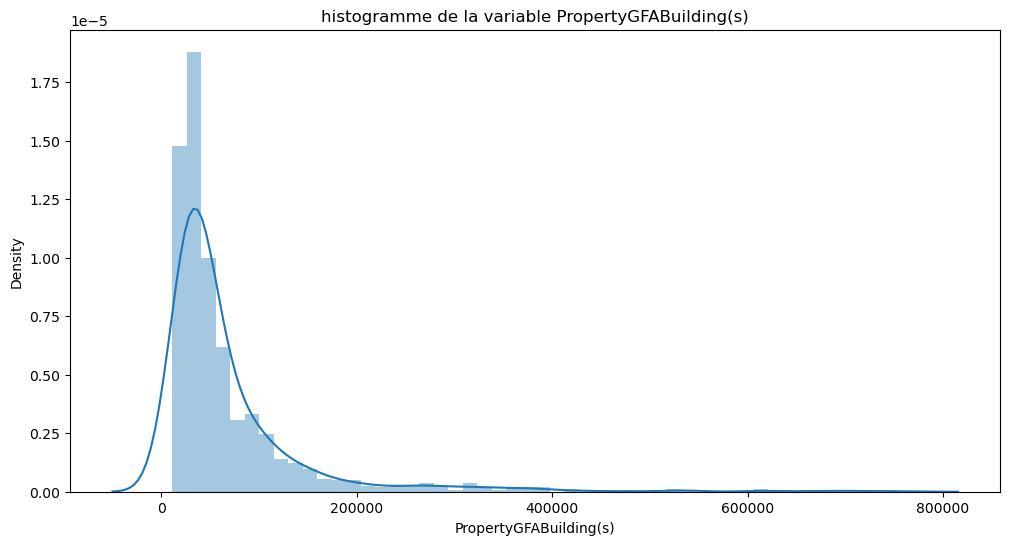

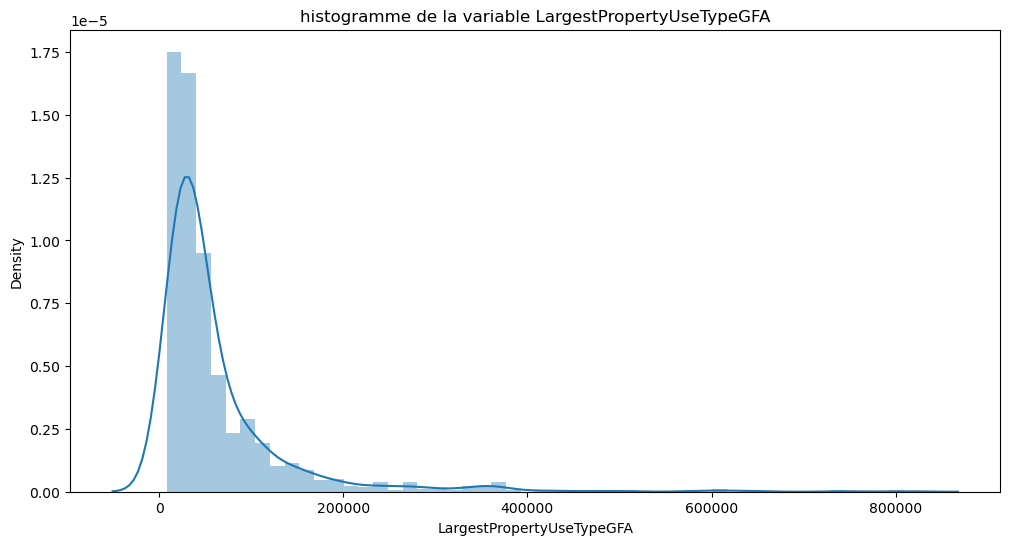

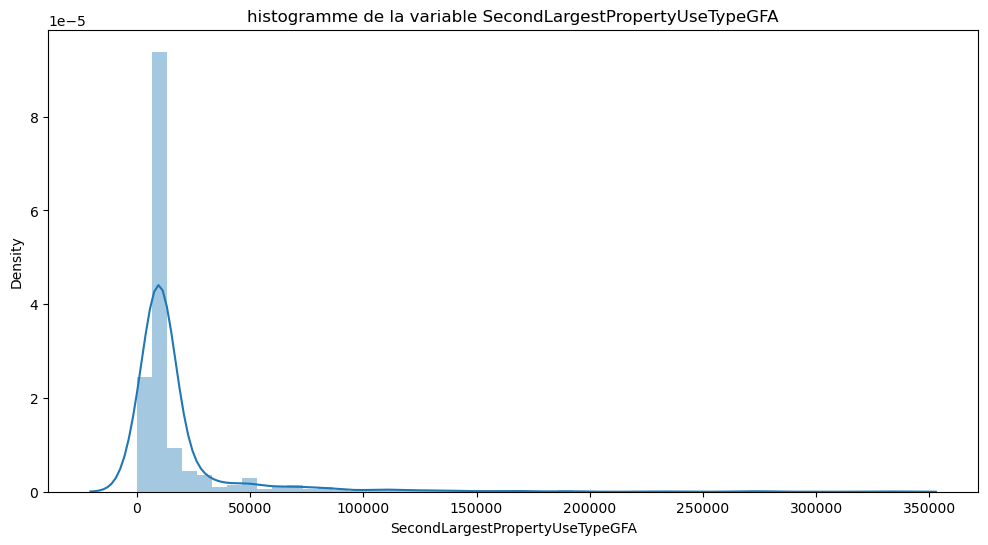

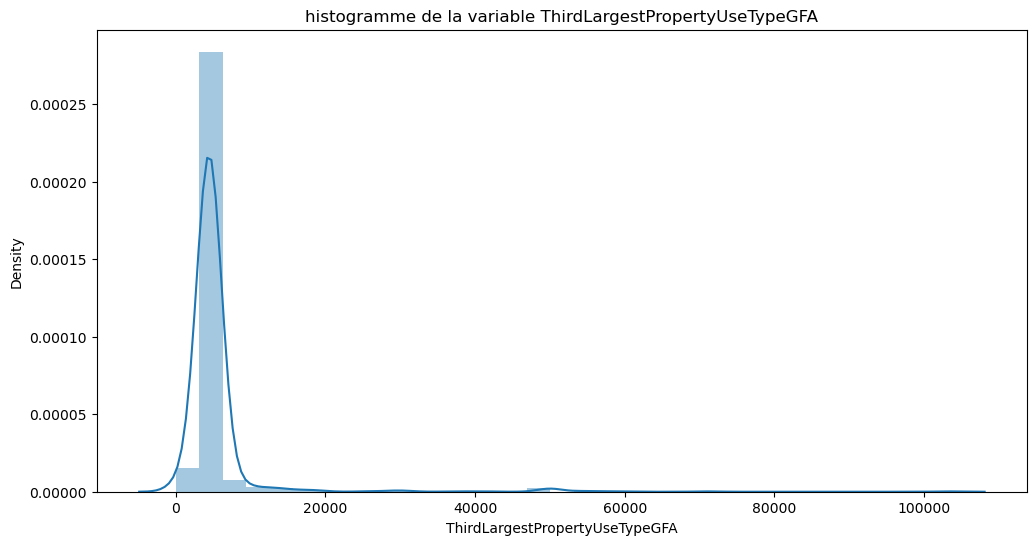

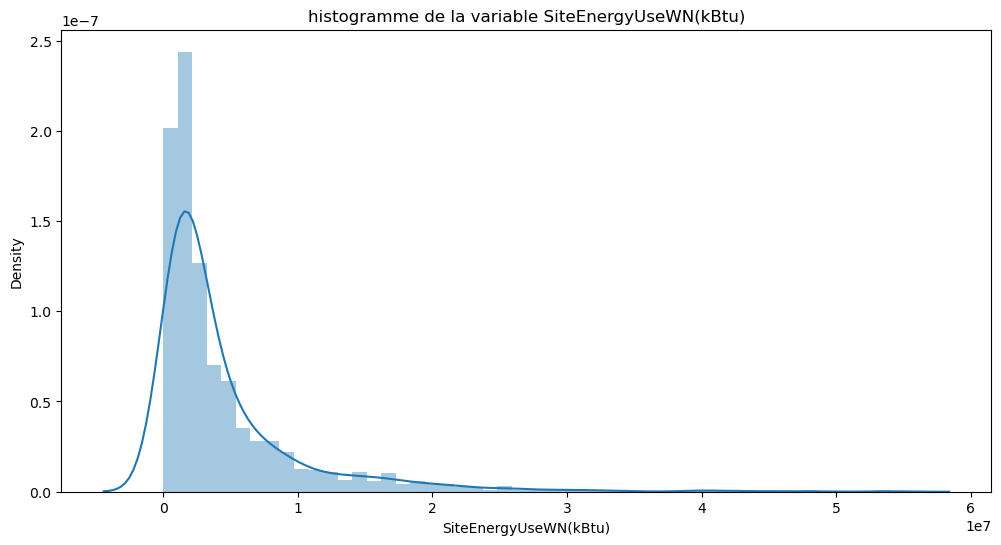

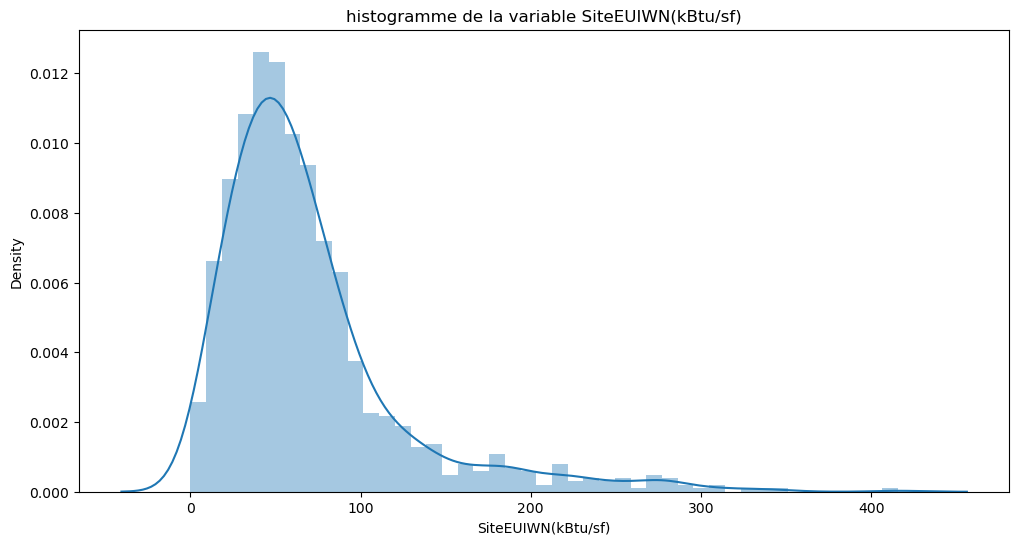

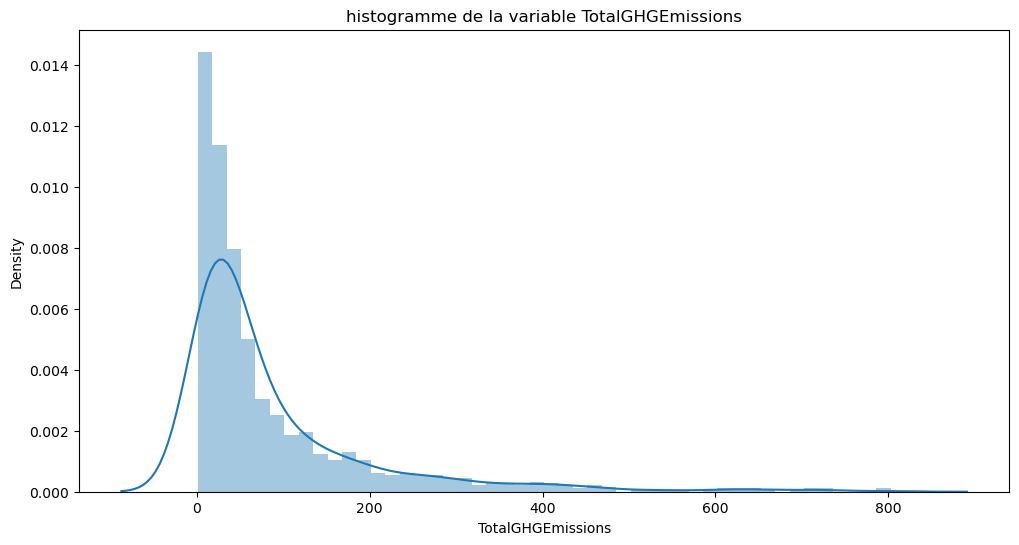

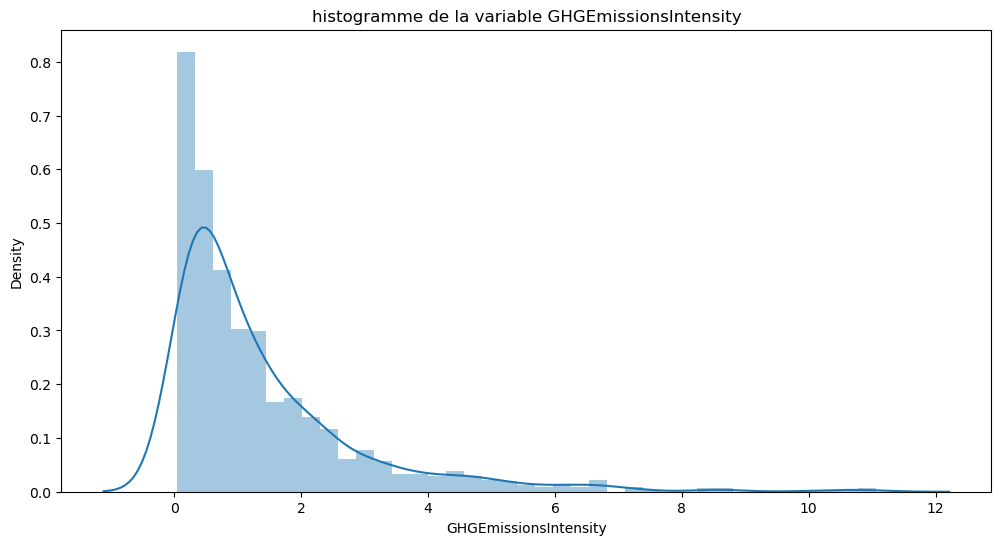

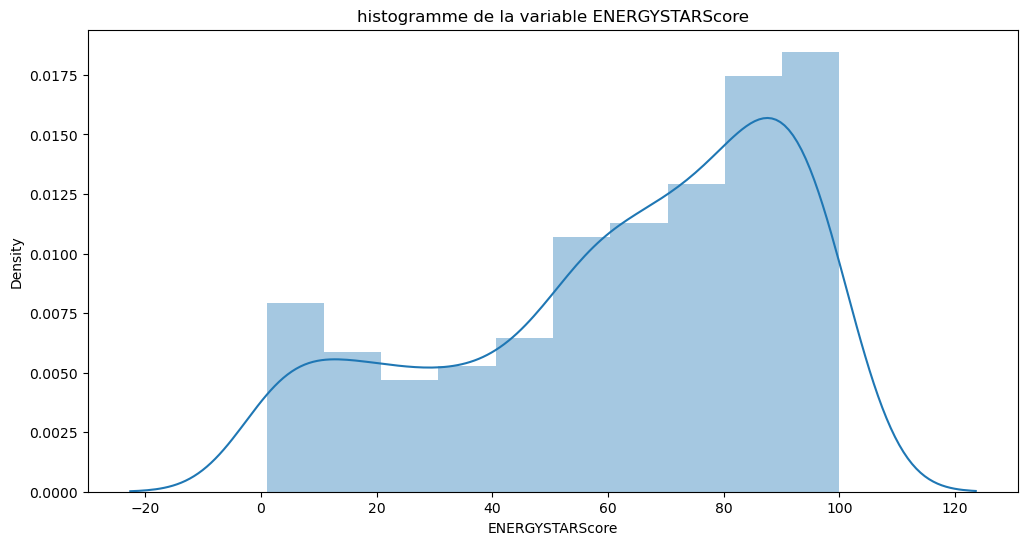

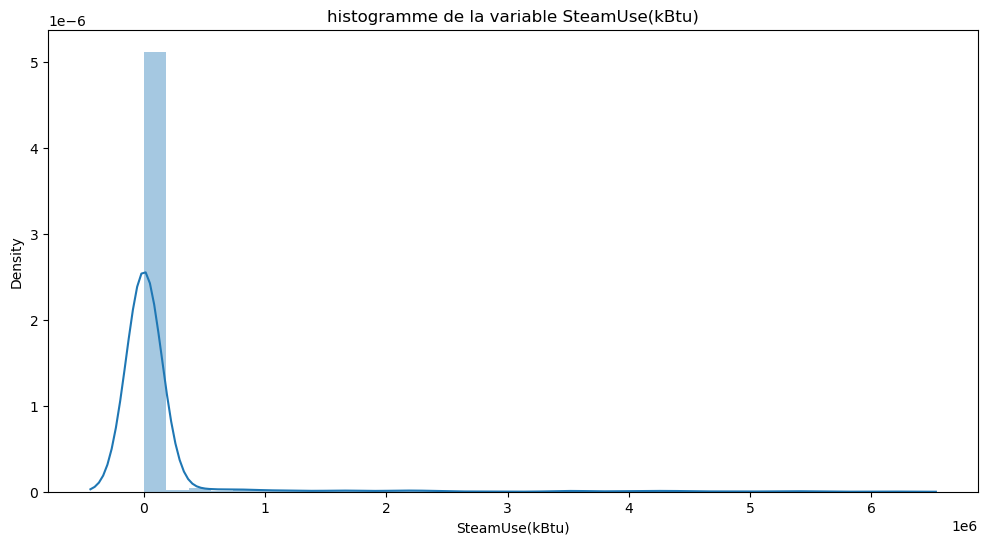

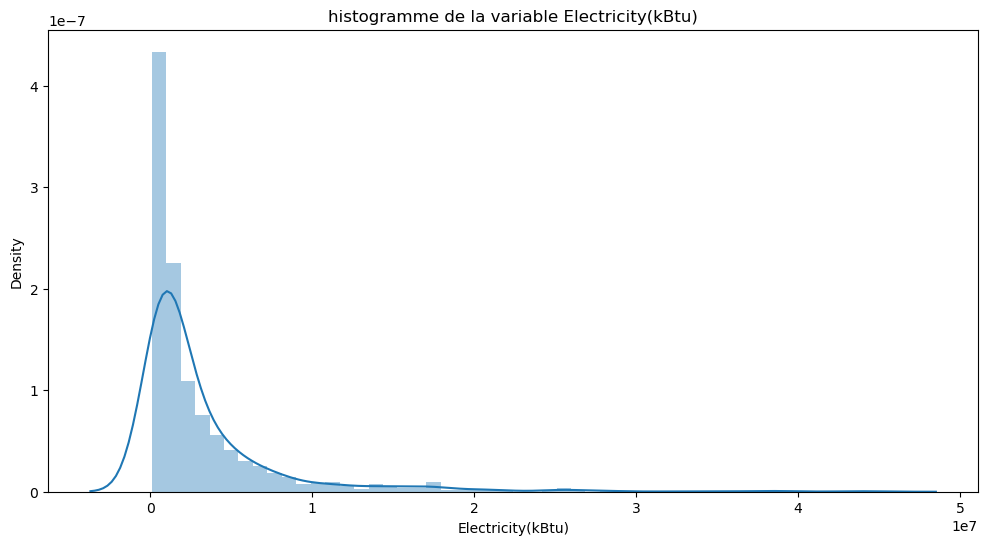

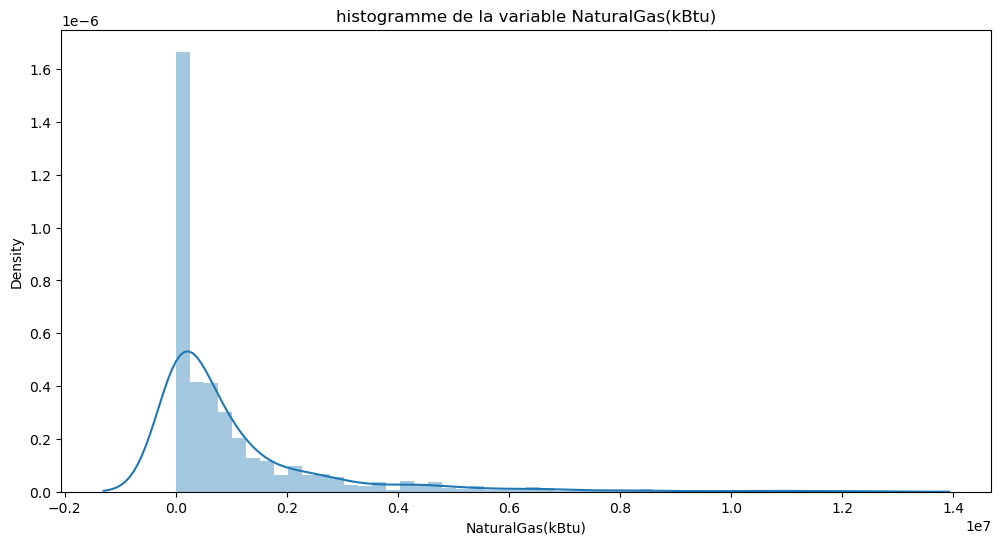

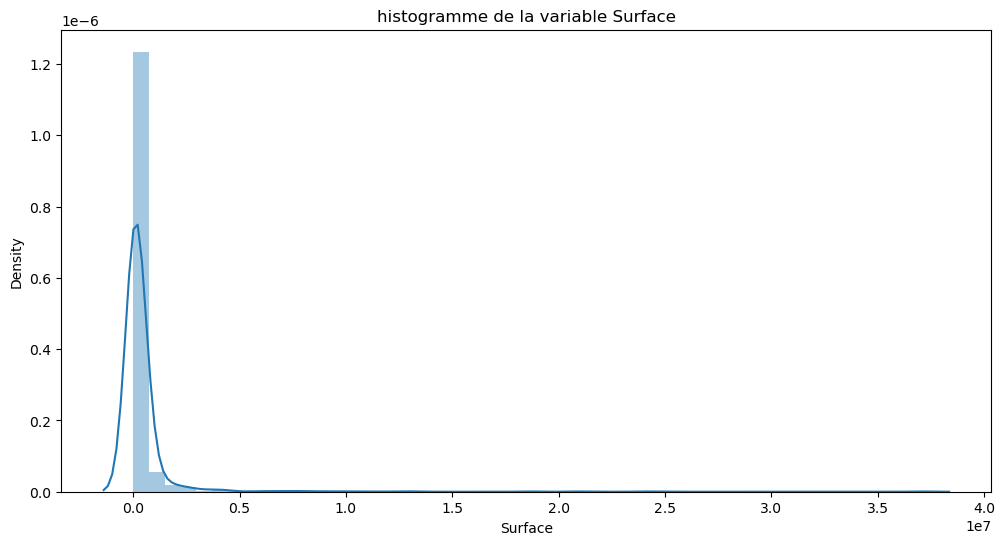

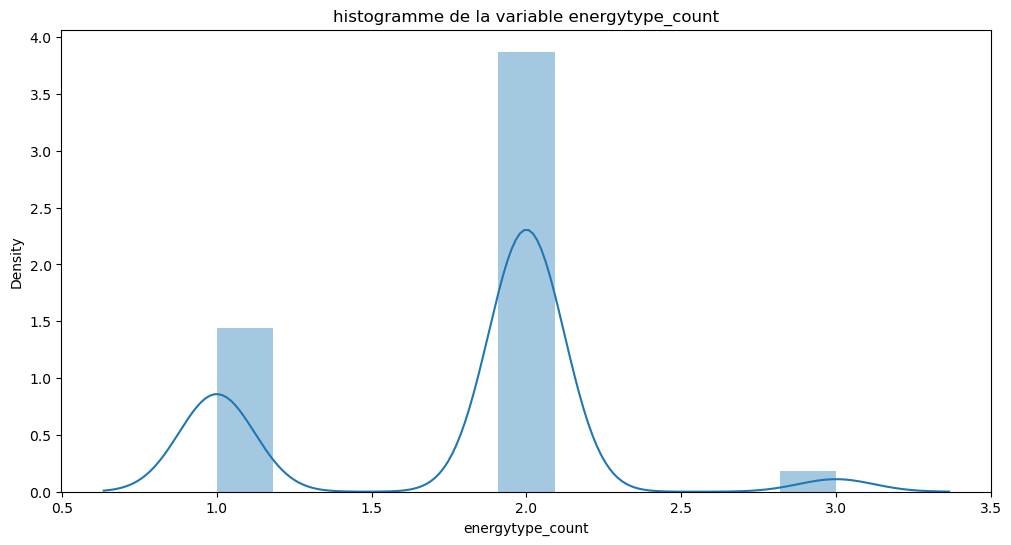

In [43]:
#histogrammes
for col in data.select_dtypes(['int64', 'float64']):
    plt.figure(figsize=(12,6))
    sns.distplot(data[col]).set_title("histogramme de la variable " +col)

#### Boxplot des variables continues 

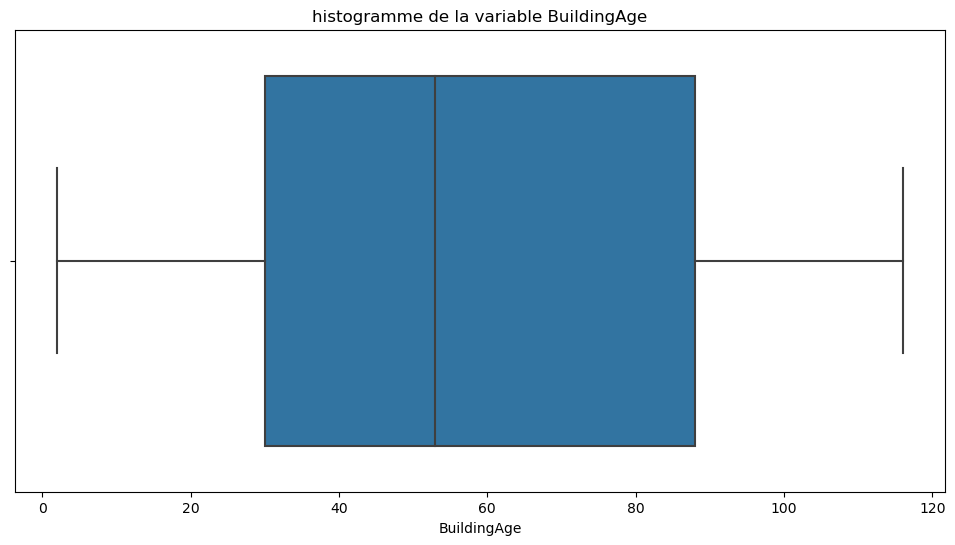

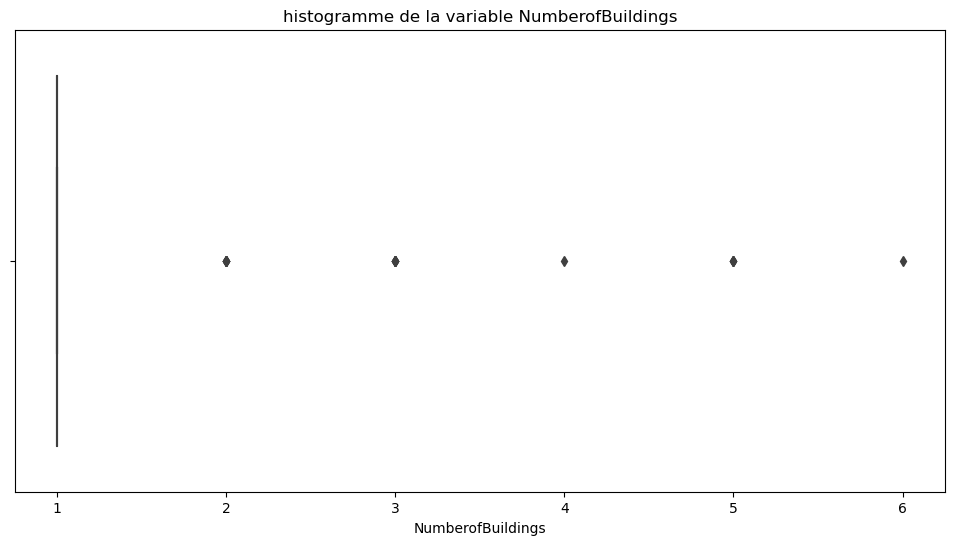

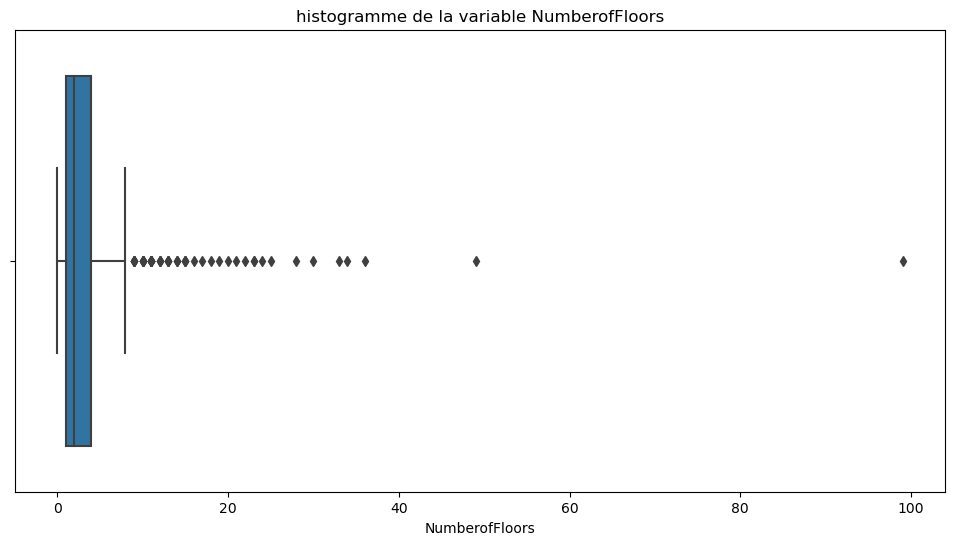

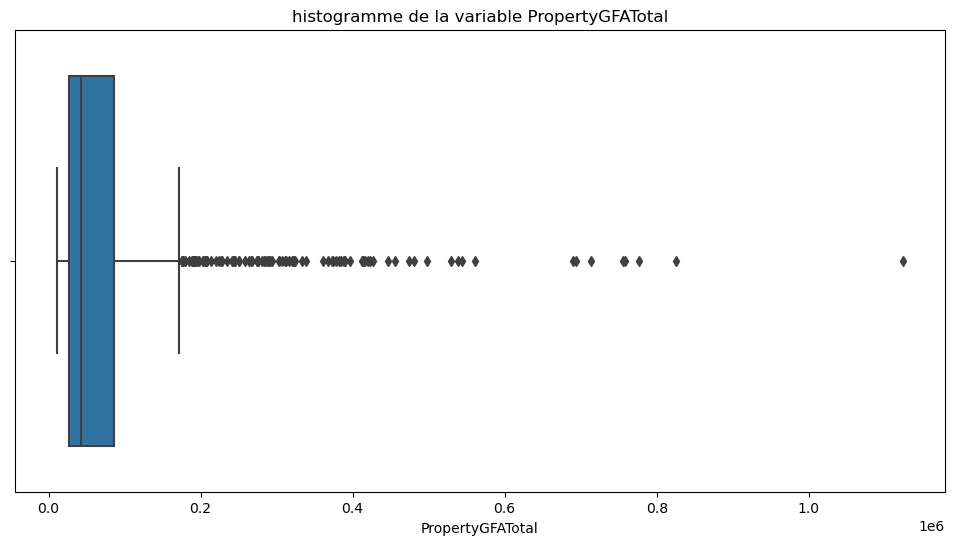

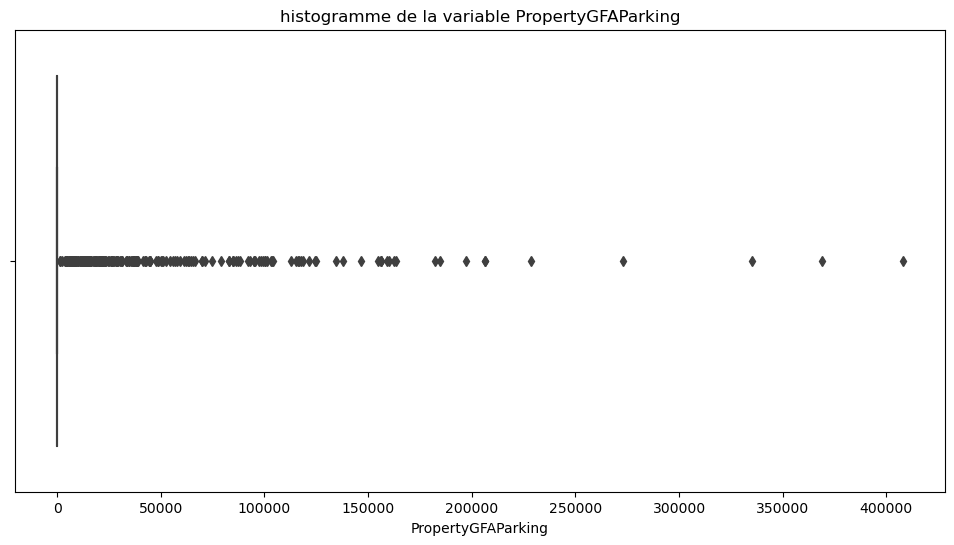

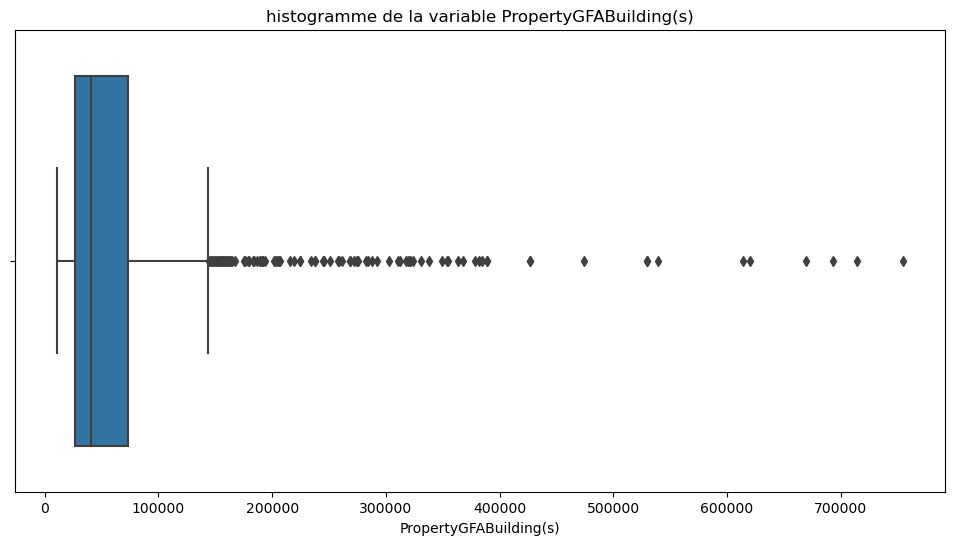

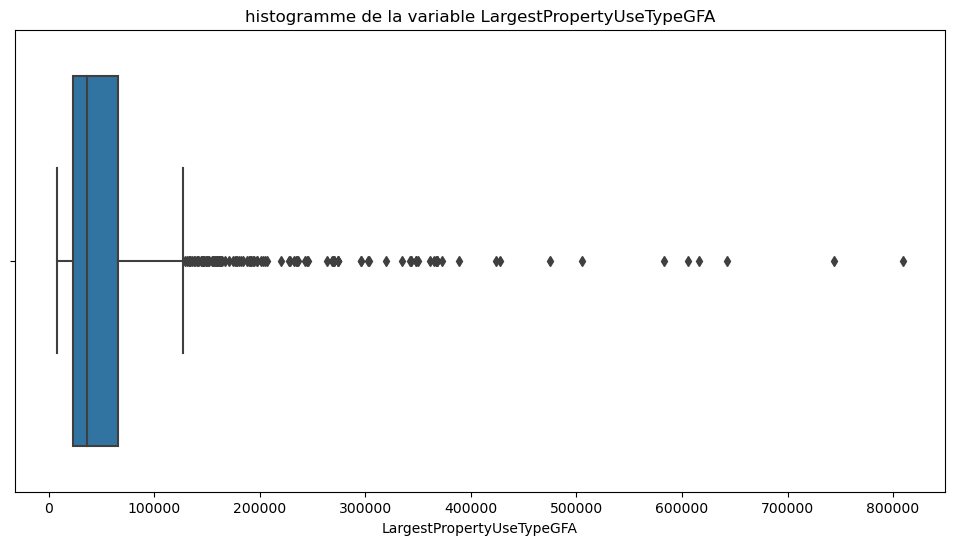

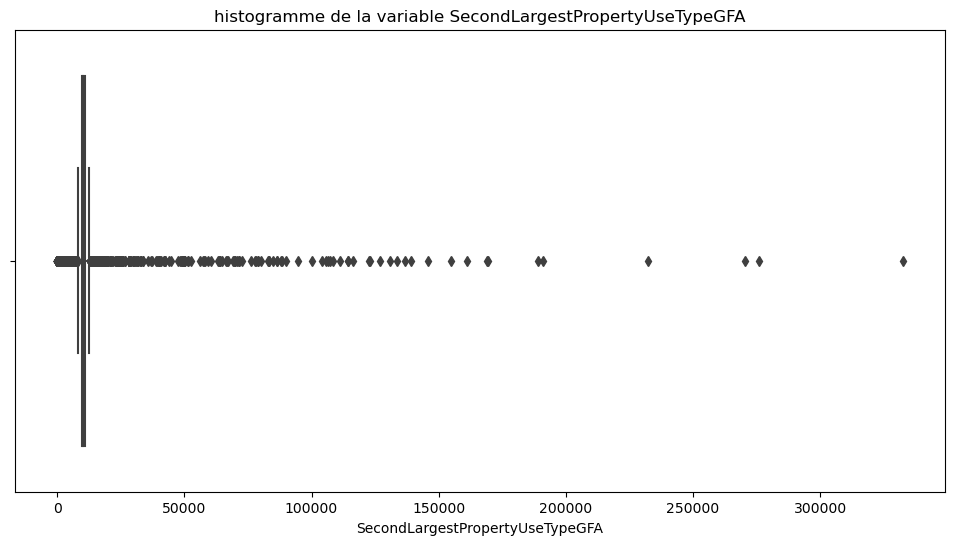

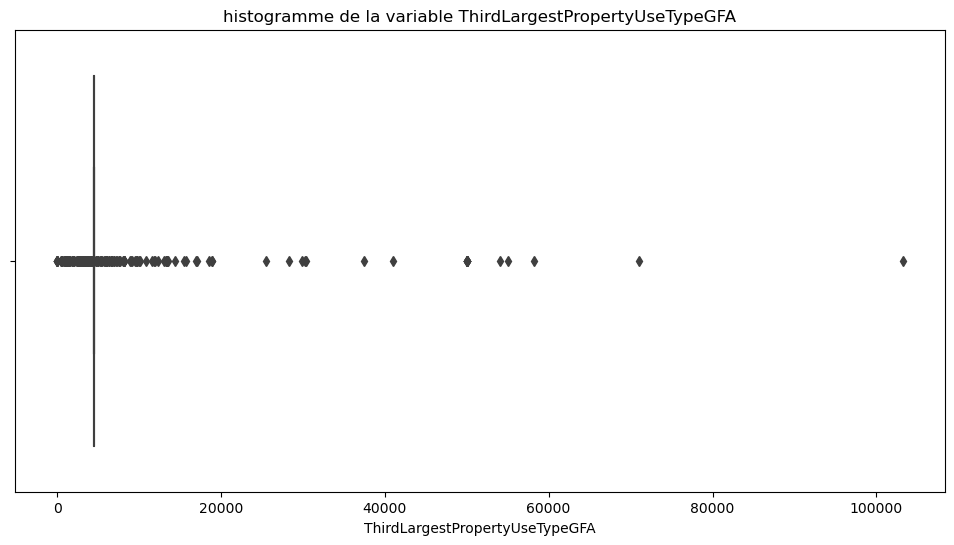

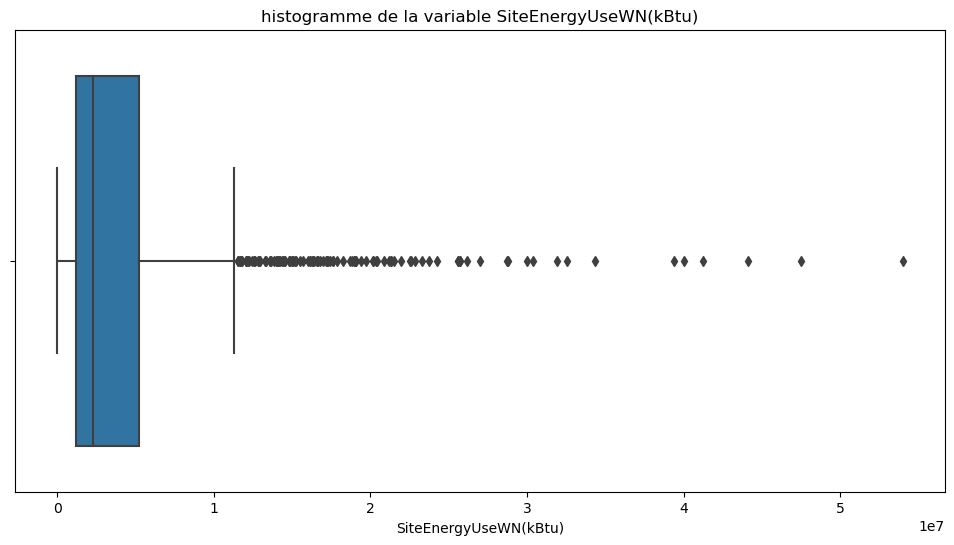

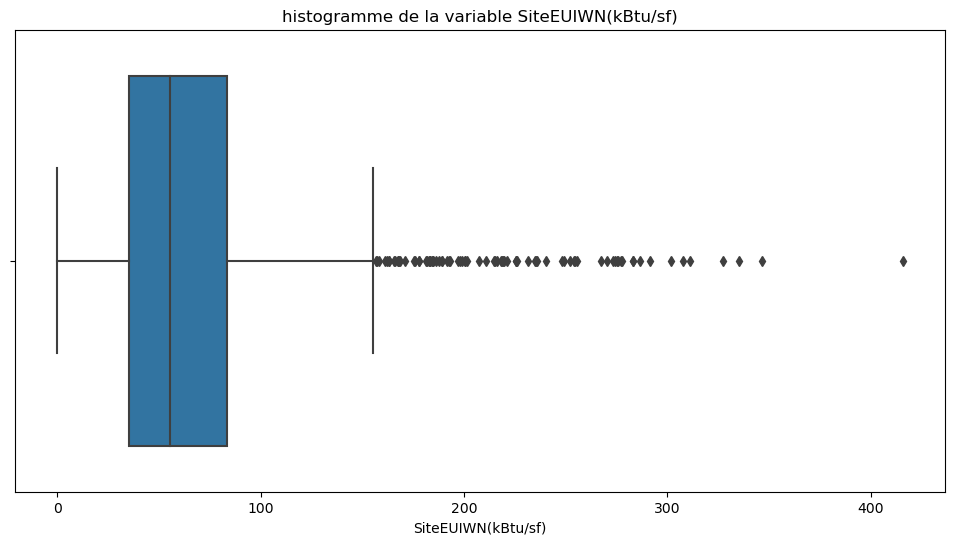

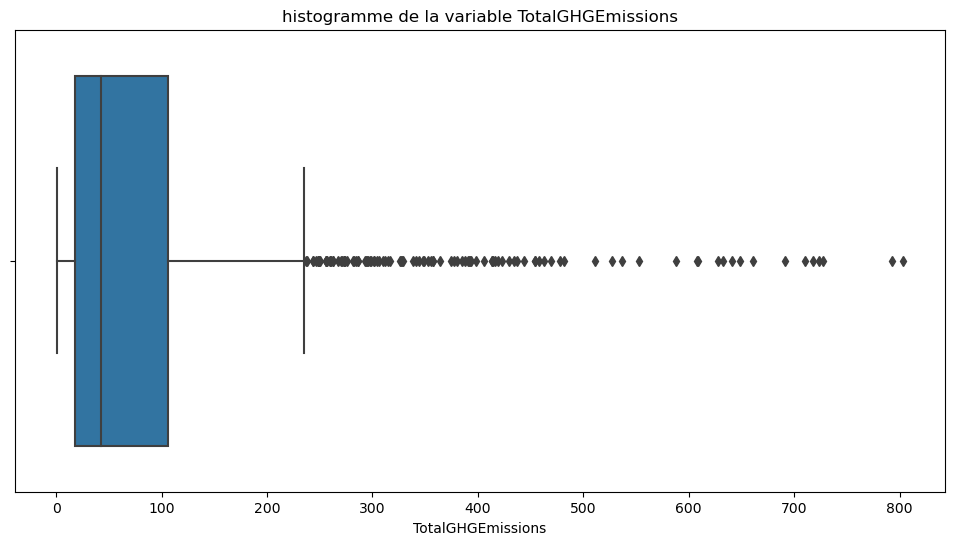

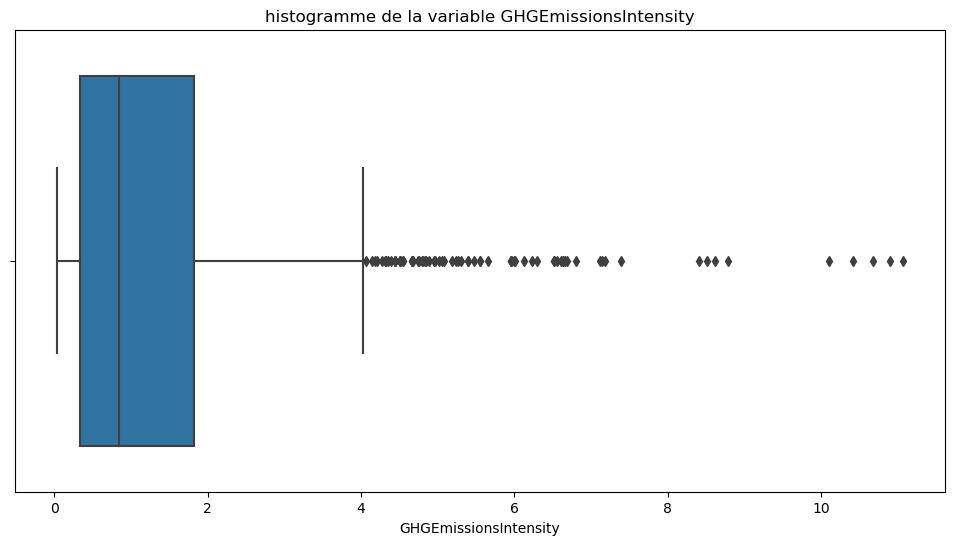

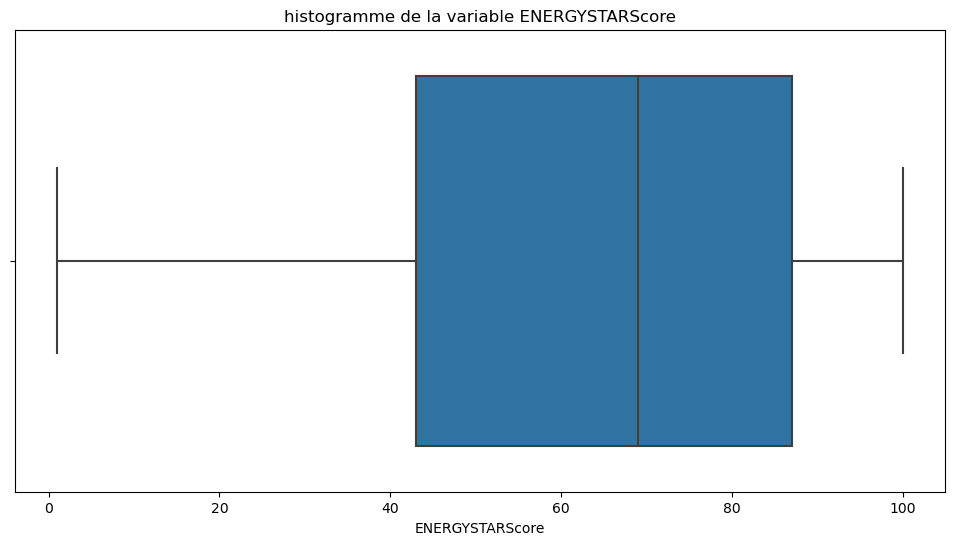

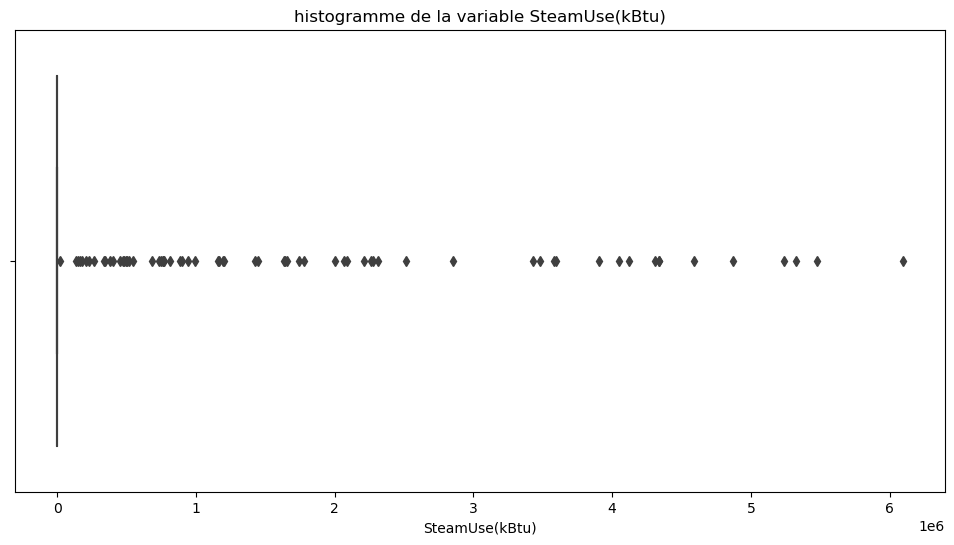

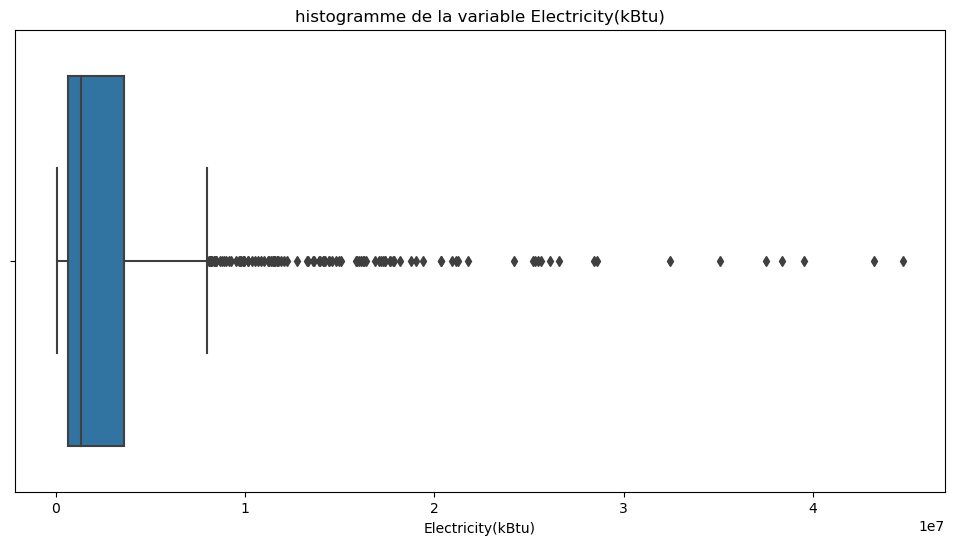

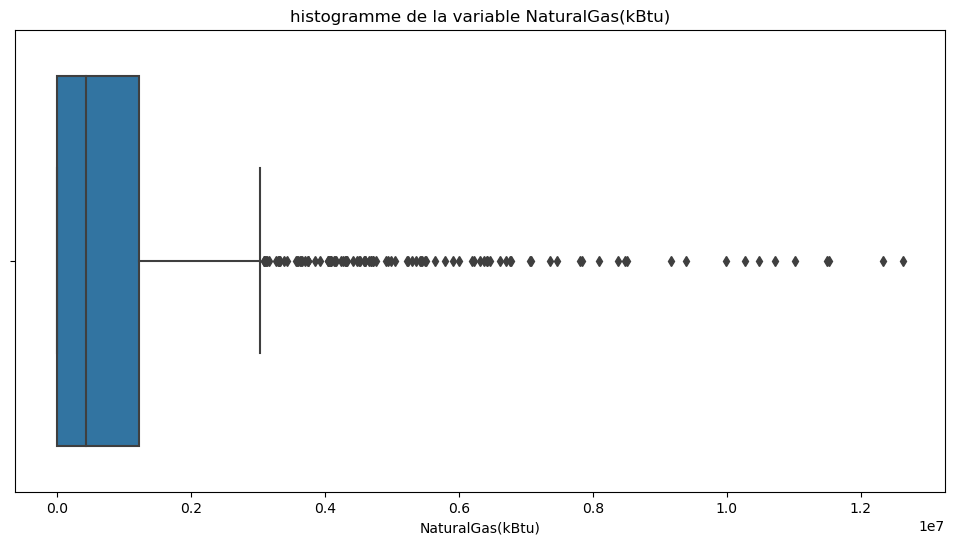

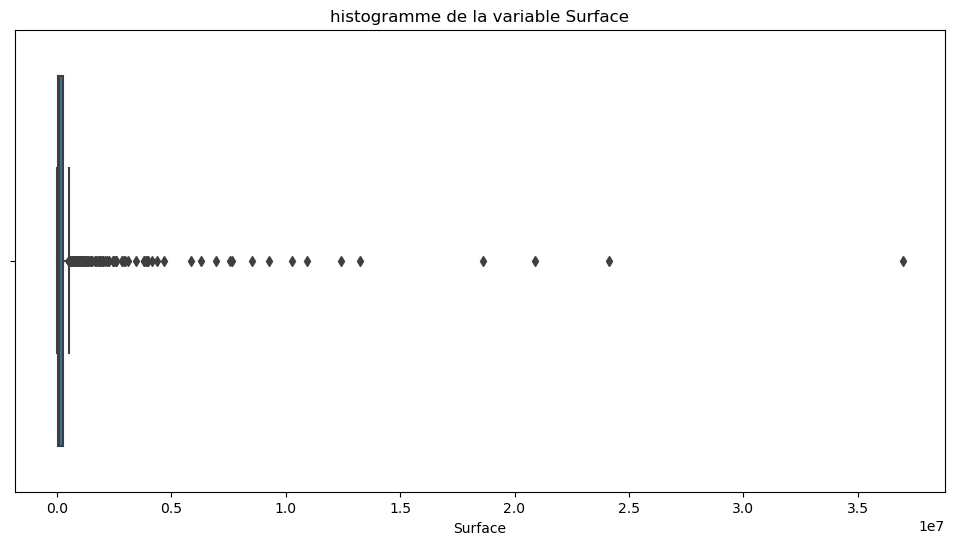

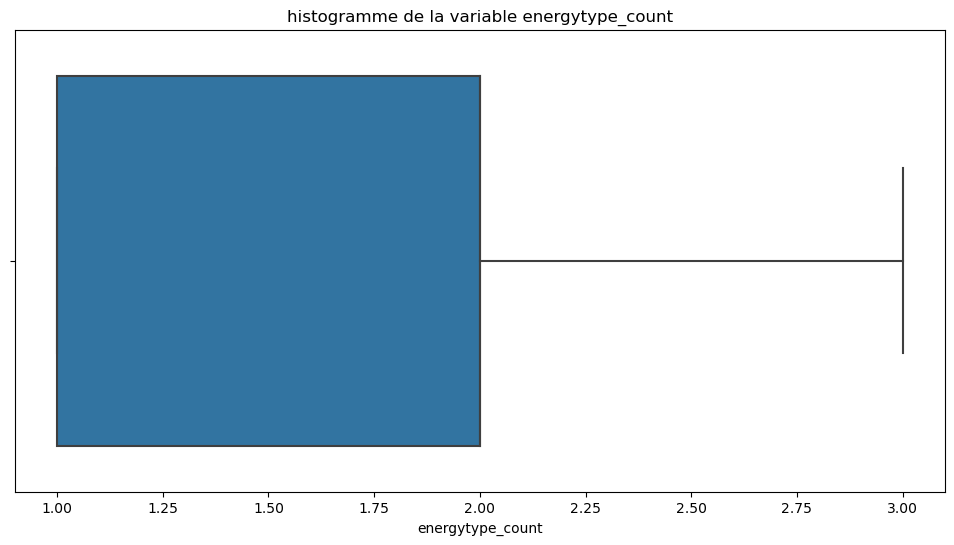

In [44]:
for col in data.select_dtypes(['int64', 'float64']):
    plt.figure(figsize=(12,6))
    sns.boxplot(x=data[col]).set_title("histogramme de la variable "+col)

#### la Skewness et le Kurtosis des variables catégorielles 

Analysons la disparité dans le dataset

In [45]:

import scipy
from scipy.stats import skew,kurtosis

for col in cont_feats:
    print ( col, "Skew" , data[col].skew())
    

BuildingAge Skew 0.222235852119161
NumberofBuildings Skew 10.046930132696183
NumberofFloors Skew 9.789631317490244
PropertyGFATotal Skew 4.055991961207692
PropertyGFAParking Skew 5.541537664509094
PropertyGFABuilding(s) Skew 4.030770747537409
LargestPropertyUseTypeGFA Skew 4.171470844319346
SecondLargestPropertyUseTypeGFA Skew 5.304536323010578
ThirdLargestPropertyUseTypeGFA Skew 8.021218196895358
SiteEnergyUseWN(kBtu) Skew 3.2232587098326517
SiteEUIWN(kBtu/sf) Skew 2.1540362960977077
TotalGHGEmissions Skew 2.716817181881349
GHGEmissionsIntensity Skew 2.457722224408541
ENERGYSTARScore Skew -0.6464744646564802
SteamUse(kBtu) Skew 6.61154264791038
Electricity(kBtu) Skew 3.772388853633315
NaturalGas(kBtu) Skew 3.027774255558623


In [46]:
for col in cont_feats:
    print (col, "kurtosis",data[col].kurtosis())
    

BuildingAge kurtosis -1.0955157307662247
NumberofBuildings kurtosis 110.6877364670355
NumberofFloors kurtosis 159.1811223452885
PropertyGFATotal kurtosis 22.864539567513187
PropertyGFAParking kurtosis 40.773875845788496
PropertyGFABuilding(s) kurtosis 21.379456761011703
LargestPropertyUseTypeGFA kurtosis 23.951101590584983
SecondLargestPropertyUseTypeGFA kurtosis 37.9824812866984
ThirdLargestPropertyUseTypeGFA kurtosis 77.49032102757667
SiteEnergyUseWN(kBtu) kurtosis 14.325982842521576
SiteEUIWN(kBtu/sf) kurtosis 5.966304673887016
TotalGHGEmissions kurtosis 8.846690954716149
GHGEmissionsIntensity kurtosis 8.022477580177085
ENERGYSTARScore kurtosis -0.7227584421930255
SteamUse(kBtu) kurtosis 47.11763448195896
Electricity(kBtu) kurtosis 18.686728056294008
NaturalGas(kBtu) kurtosis 11.363774167467884


Nous pouvons déduire à travers les resultats que les variables sont annormalements distribuées

#### Distribution des variables catégorielles 

In [47]:
#les variables qualitatives
for col in data.select_dtypes('object'):
    print(f'{col :-<350} {data[col].unique()}')

BuildingType-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- ['NonResidential' 'Nonresidential COS' 'SPS-District K-12' 'Campus']
PrimaryPropertyType------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- ['Hotel/Senior Care/Housing' 'Other' 'Mixed Use Property' 'Education'
 'Small- and Mid-Sized Office' 'Self-Storage Facility' 'Warehouse'
 'Residence Hall' 'Retail' 'Distribution Center' 'Leisure' 'Health'
 'Large Office' 'Laborat

#### Barplot des variables catégorielles 

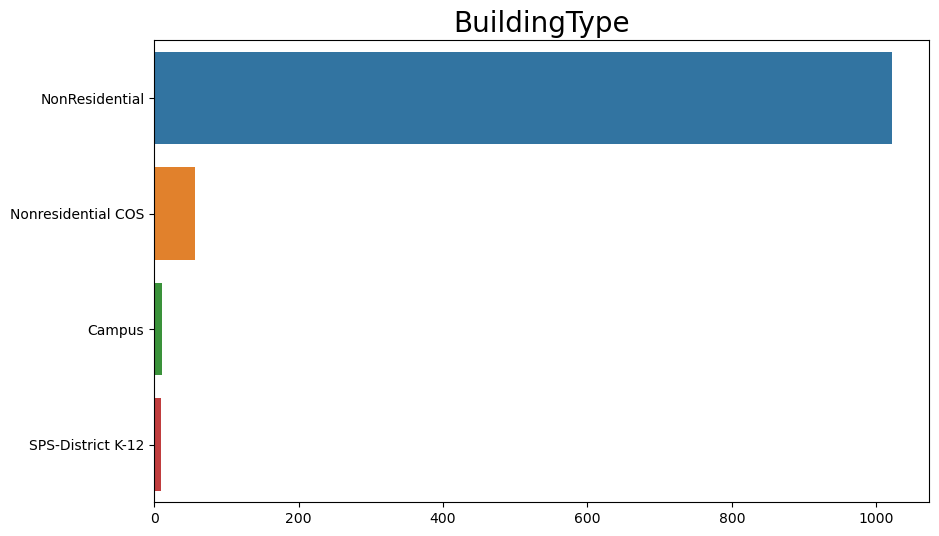

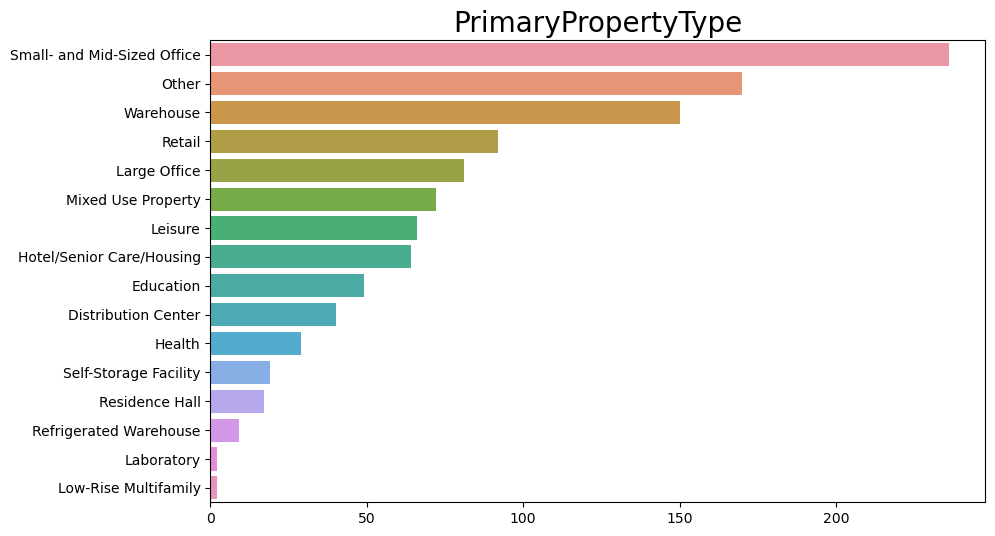

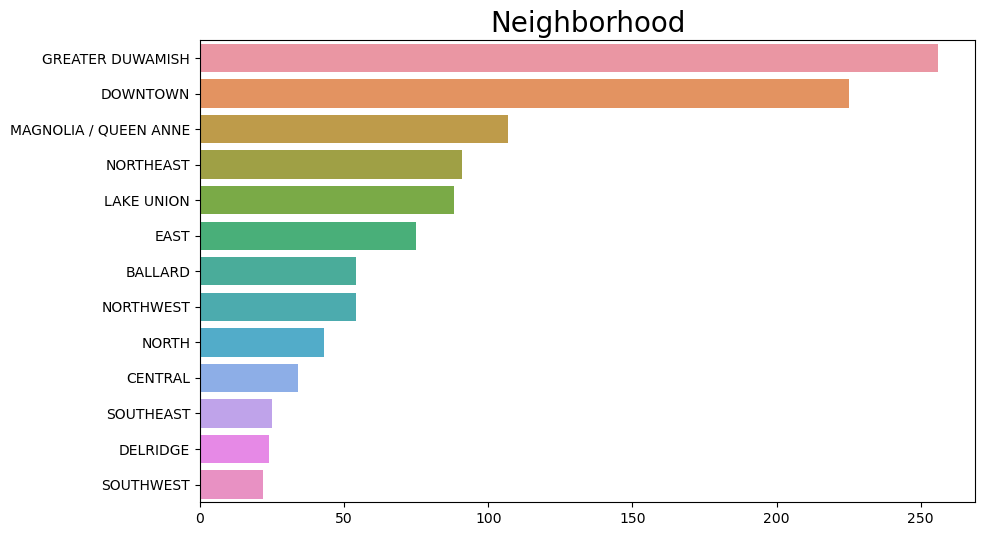

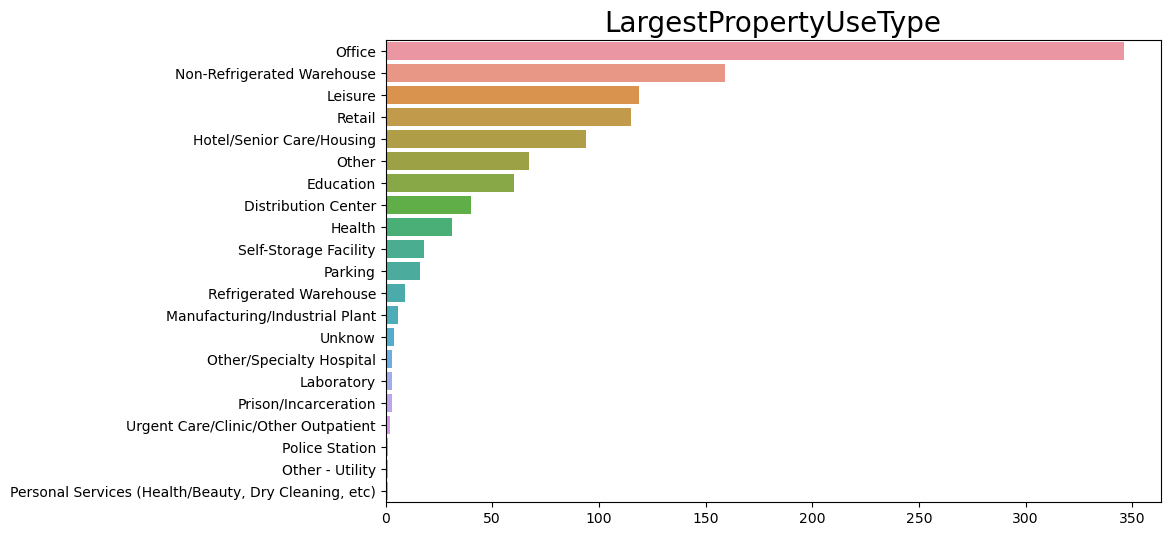

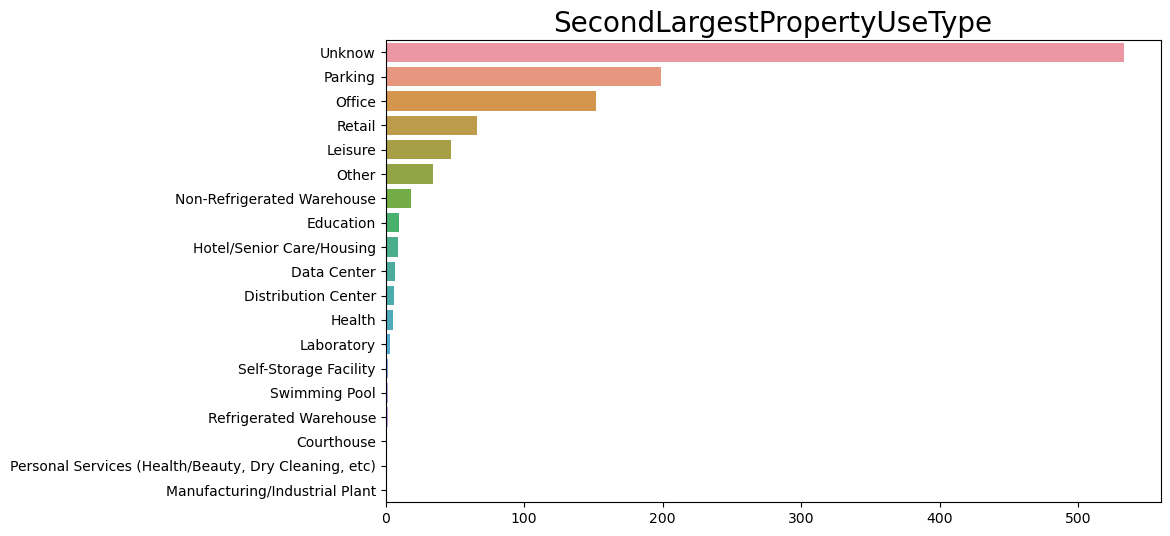

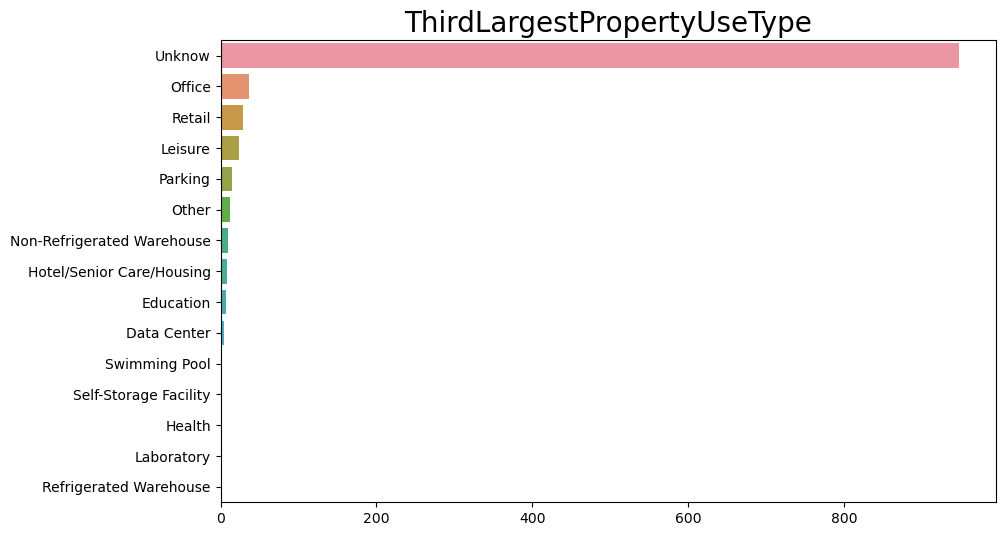

In [48]:
for i in cat_feats:
    comptage=data[i].value_counts()
    plt.figure(figsize=(10,6))
    plt.title(i, size=20)
    sns.barplot(y=comptage.index, x=comptage.values)

### Analyse Bivariée

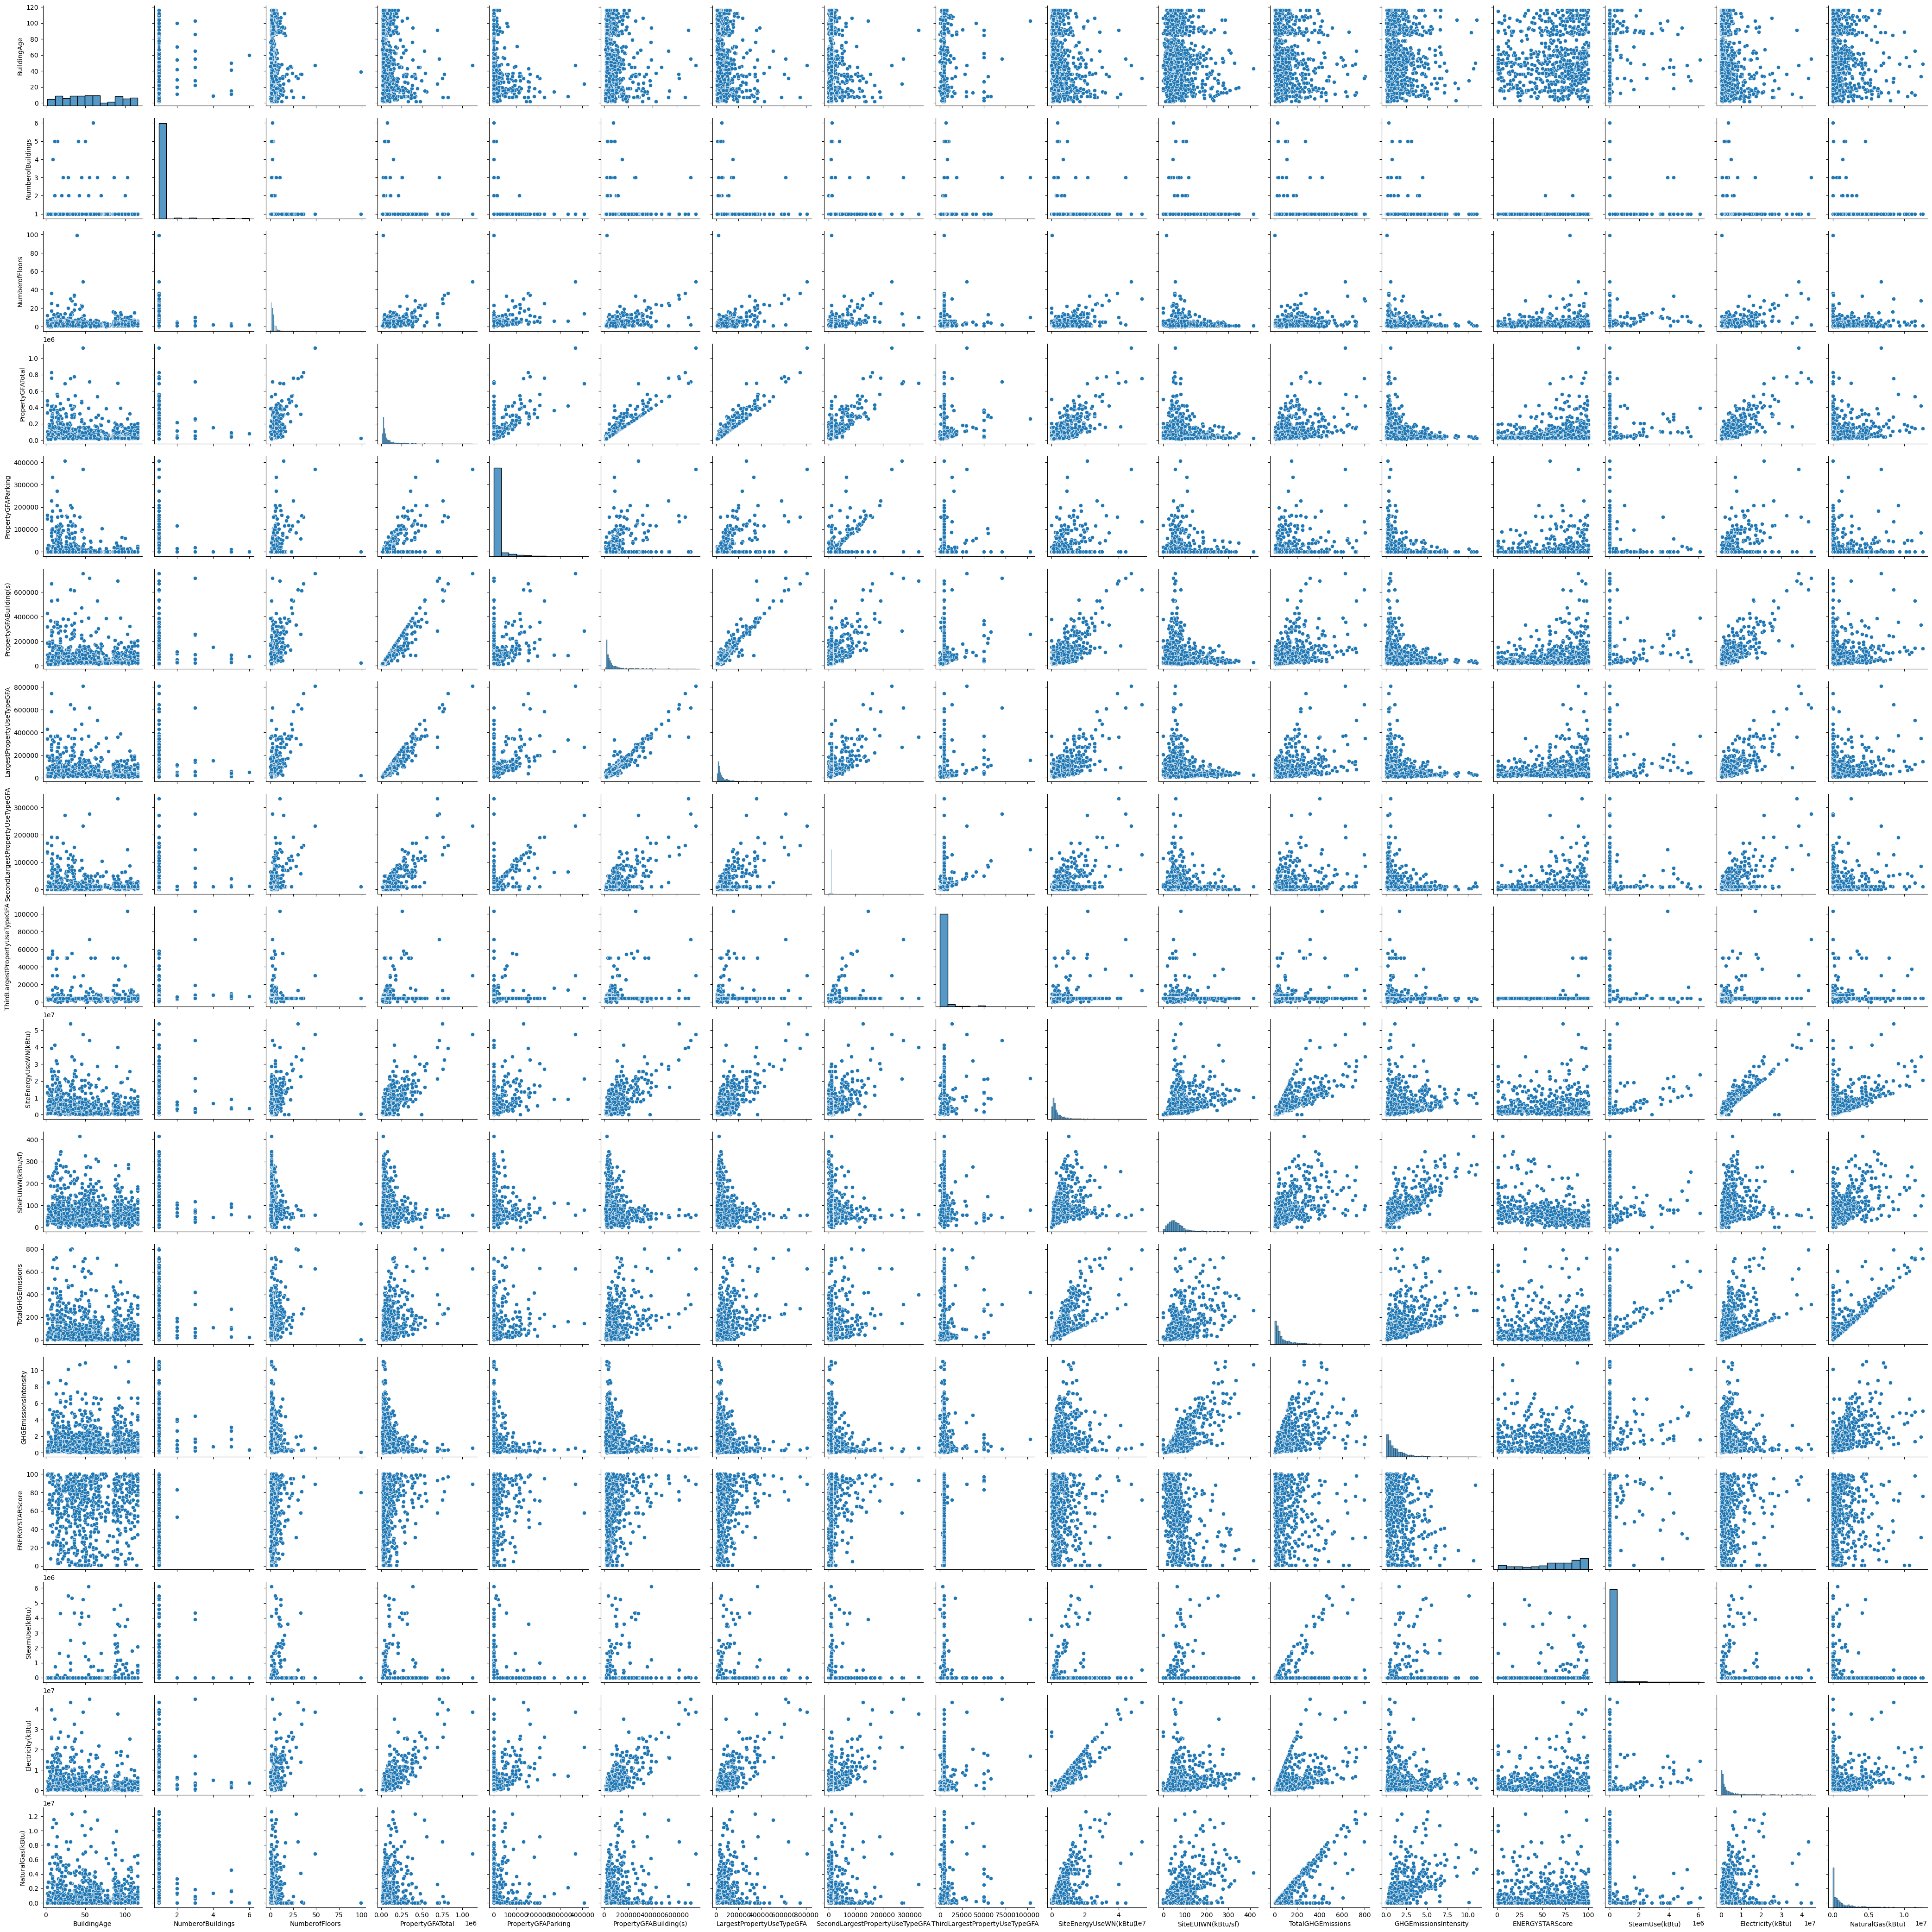

In [49]:
sns.pairplot(data[cont_feats])

#### La matrice de correlation

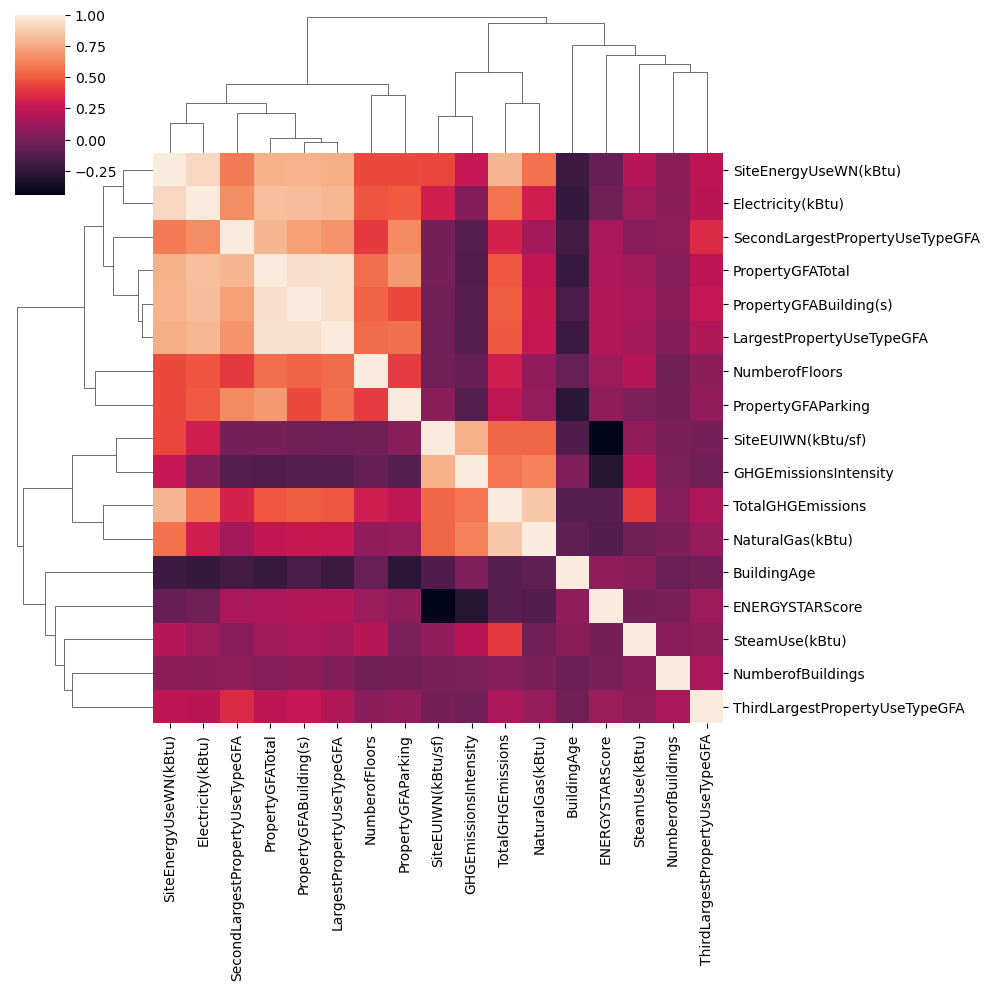

In [50]:
sns.clustermap(data[cont_feats].corr())

### Indépendance des variables 

In [51]:
columns=['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)','LargestPropertyUseTypeGFA']


In [52]:
def khi2(data,cont_feats):
    alpha=0.05
    x= pd.cut(data['SiteEnergyUseWN(kBtu)'], 20)
    for col in cont_feats:
        print('-'*20)
       
        print("test de khi2 entre 'SiteEnergyUseWN(kBtu)'  et " , col)
        y= pd.cut(data[col], 20)
        tab_contingence= pd.crosstab(x.array, y.array)
        stat_chi2, p, dof, expected_table = chi2_contingency(tab_contingence.values)
        critical= chi2.ppf(1-alpha, dof)
        if p <= alpha: 
            print('Variables non indépendants (H0 Rejetée)')
        else : 
            print('H0 non rejetée')
        
khi2(data,cont_feats)   

--------------------
test de khi2 entre 'SiteEnergyUseWN(kBtu)'  et  BuildingAge
Variables non indépendants (H0 Rejetée)
--------------------
test de khi2 entre 'SiteEnergyUseWN(kBtu)'  et  NumberofBuildings
Variables non indépendants (H0 Rejetée)
--------------------
test de khi2 entre 'SiteEnergyUseWN(kBtu)'  et  NumberofFloors
Variables non indépendants (H0 Rejetée)
--------------------
test de khi2 entre 'SiteEnergyUseWN(kBtu)'  et  PropertyGFATotal
Variables non indépendants (H0 Rejetée)
--------------------
test de khi2 entre 'SiteEnergyUseWN(kBtu)'  et  PropertyGFAParking
Variables non indépendants (H0 Rejetée)
--------------------
test de khi2 entre 'SiteEnergyUseWN(kBtu)'  et  PropertyGFABuilding(s)
Variables non indépendants (H0 Rejetée)
--------------------
test de khi2 entre 'SiteEnergyUseWN(kBtu)'  et  LargestPropertyUseTypeGFA
Variables non indépendants (H0 Rejetée)
--------------------
test de khi2 entre 'SiteEnergyUseWN(kBtu)'  et  SecondLargestPropertyUseTypeGFA
Variab

In [53]:
def khi2(data,cont_feats):
    alpha=0.05
    x= pd.cut(data['TotalGHGEmissions'], 20)
    for col in cont_feats:
        print('-'*20)
       
        print("test de khi2 entre 'TotalGHGEmissions'  et " , col)
        y= pd.cut(data[col], 20)
        tab_contingence= pd.crosstab(x.array, y.array)
        stat_chi2, p, dof, expected_table = chi2_contingency(tab_contingence.values)
        critical= chi2.ppf(1-alpha, dof)
        if p <= alpha: 
            print('Variables non indépendants (H0 Rejetée)')
        else : 
            print('H0 non rejetée')
        
khi2(data,cont_feats)   

--------------------
test de khi2 entre 'TotalGHGEmissions'  et  BuildingAge
H0 non rejetée
--------------------
test de khi2 entre 'TotalGHGEmissions'  et  NumberofBuildings
H0 non rejetée
--------------------
test de khi2 entre 'TotalGHGEmissions'  et  NumberofFloors
Variables non indépendants (H0 Rejetée)
--------------------
test de khi2 entre 'TotalGHGEmissions'  et  PropertyGFATotal
Variables non indépendants (H0 Rejetée)
--------------------
test de khi2 entre 'TotalGHGEmissions'  et  PropertyGFAParking
Variables non indépendants (H0 Rejetée)
--------------------
test de khi2 entre 'TotalGHGEmissions'  et  PropertyGFABuilding(s)
Variables non indépendants (H0 Rejetée)
--------------------
test de khi2 entre 'TotalGHGEmissions'  et  LargestPropertyUseTypeGFA
Variables non indépendants (H0 Rejetée)
--------------------
test de khi2 entre 'TotalGHGEmissions'  et  SecondLargestPropertyUseTypeGFA
Variables non indépendants (H0 Rejetée)
--------------------
test de khi2 entre 'TotalGH

In [54]:
#exportation de la table
data.to_csv('data_clean.csv', index=False)